In [1]:
import traceback
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from pprint import pprint
from scipy.special import logsumexp
from sklearn.cluster import KMeans
from scipy import interpolate
from scipy.ndimage.filters import gaussian_filter

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
rng = np.random.RandomState(42)

source : http://approximateinference.org/2017/accepted/Zinkov2017.pdf
source : https://towardsdatascience.com/implement-expectation-maximization-em-algorithm-in-python-from-scratch-f1278d1b9137

In [4]:
df = pd.read_csv("../data/X_station_day.csv")

In [5]:
df.rename(columns={"precipitations": "current_precipitations"}, inplace=True)

## EM
 M-step :

$$ \pi = \frac{\sum_{i=1}^{n}\mathcal{Q}(y^i=1|x^i)}{n} $$

$$ \mu_j = \frac{\sum_{i=1}^{n}x^i\mathcal{Q}(y^i=j|x^i)}{\sum_{i=1}^{n}\mathcal{Q}(y^i=j|x^i)} $$

$$ \Sigma_j = \frac{\sum_{i=1}^{n}\mathcal{Q}(y^i=j|x^i)(x^i-\mu_j)(x^i-\mu_j)^T}{\sum_{i=1}^{n}\mathcal{Q}(y^i=j|x^i)} $$

## 1 dimension

In [9]:
class EM_1D():
    def __init__(self, x: np.ndarray, nb_dist=2, split_ratio=0.1, threshold=0.01, minimum_sigma=1e-5, talk=False):
        self.talk = talk  # whether to display information or not
        self.threshold = threshold  # threshold ratio to trigger stop_fitting
        self.minimum_sigma = minimum_sigma  # to avoid sigma being 0
        self.stop_fitting = False  # stop fitting if maximum iterations reached or threshold passed
        self.nb_dist = nb_dist  # number of distributions to fit

        self.split_ratio = split_ratio  # part of x to keep to initialize the parameters
        self.x_all = x  # backup of whole x data
        self.idx_sample = None  # index of x_sample for initialization
        self.x_sample = None  # sample for initialization
        self.x = None  # training part of x
        self.split_x()  # fill x_sample, idx_sample and x

        self.mu = None  # average
        self.sigma = None  # standard deviation
        self.w = None  # weights
        self.init_params()  # initialize the above

        self.history = None  # history
        self.init_history()  # initialize history

        self.r = None  # declare r to anticipate fit()

        self.initial_record = None  # declare variable, used in average_fit()
        self.history_record = None  # declare variable, used in average_fit()
        self.clustered_distributions = None  # declare variable, used in average_fit()

        self.colors = ["blue", "red", "orange", "green", "magenta"]

    def split_x(self):
        self.idx_sample = rng.choice(np.arange(self.x_all.shape[0]),
                                     replace=False,
                                     size=int(self.x_all.shape[0] * self.split_ratio))
        self.x_sample = self.x_all[self.idx_sample]
        self.x = np.delete(self.x_all, self.idx_sample, axis=0)

    def init_params(self):
        mu = rng.normal(loc=np.mean(self.x_sample),
                        scale=20,
                        size=self.nb_dist)
        sigma = np.abs(rng.normal(loc=np.sqrt(np.var(self.x_sample)),
                                  scale=20,
                                  size=self.nb_dist))
        w = np.abs(rng.normal(loc=1,
                              scale=0.2,
                              size=self.nb_dist))
        w /= w.sum()
        if self.talk:
            print("Initial parameters :")
            print("\t - mu :    {}".format(np.round(mu, 2)))
            print("\t - sigma : {}".format(np.round(sigma, 2)))
            print("\t - w :     {}".format(np.round(w, 2)))
        self.mu, self.sigma, self.w = mu, sigma, w

    def init_history(self):
        history = {"mu": [self.mu],
                   "sigma": [self.sigma],
                   "w": [self.w]}
        self.history = history

    def update_h(self):
        self.history["mu"].append(self.mu)
        self.history["sigma"].append(self.sigma)
        self.history["w"].append(self.w)

    def e_step(self):
        x = self.x[None, :]
        mu = self.mu[:, None]
        sigma = self.sigma[:, None]
        # r is the likelyhood of each point of x given the normal distribution N(mu,sigma)
        self.r = stats.norm.pdf(x, mu, sigma)
        self.r = self.r / self.r.sum(axis=0)

    def m_step(self):
        n = self.x.shape[0]
        self.w = np.sum(self.r, axis=1) / n
        self.mu = np.sum(self.x * self.r, axis=1) / np.sum(self.r, axis=1)
        sigma = []
        for j in range(self.nb_dist):
            sigma.append(
                np.sqrt(np.sum(self.r[j, :] * (self.x - self.mu[j]) * (self.x - self.mu[j])) / np.sum(self.r[j, :])))
            if sigma[-1] == 0:
                print(
                    "WARNING : sigma == 0, set sigma to minimum_sigma = {}".format(self.minimum_sigma))
                sigma[-1] = self.minimum_sigma
        self.sigma = np.array(sigma)

    def fit(self, max_iters=100, plot=False):
        self.stop_fitting = False
        for i in range(max_iters):
            if self.talk and i % int(max_iters // 100 + 1) == 0:
                print("{} %".format(int(i / max_iters * 100)).rjust(5), end="\r")

            self.e_step()
            self.m_step()
            self.update_h()

            self.check_change()
            if self.stop_fitting:
                break

        if self.talk:
            print("\n")
            if self.stop_fitting:
                print("Threshold reached, less than {} % difference.".format(self.threshold * 100))
            else:
                print("100 %")
            print("Final parameters :\n\tmu :    {}\n\tsigma : {}\n\tw :     {}".format(self.history["mu"][-1],
                                                                                        self.history["sigma"][-1],
                                                                                        self.history["w"][-1]))

        if plot:
            self.plot_progression()

    def check_change(self):
        mu_old = self.history["mu"][-2]
        sigma_old = self.history["sigma"][-2]
        w_old = self.history["w"][-2]
        if any(self.mu == 0):
            delta_mu = np.max(np.abs((mu_old - self.mu) / (self.mu + 1)))
        else:
            delta_mu = np.max(np.abs((mu_old - self.mu) / self.mu))
        delta_sigma = np.max(np.abs((sigma_old - self.sigma) / self.sigma))
        if any(self.w == 0):
            delta_w = np.max(np.abs((w_old - self.w) / (self.w + 1)))
        else:
            delta_w = np.max(np.abs((w_old - self.w) / self.w))
        delta = max(delta_mu, delta_sigma, delta_w)
        if delta < self.threshold:
            self.stop_fitting = True

    def average_fit(self, runs=3, max_iters=100, plot=True, plot_title=""):
        """
        to avoid initialization issues, average over [runs] fit() and different initializations.
        :param plot_title: title of the plot of plot
        :param runs: number of fit() to execute
        :param max_iters: maximum number of iterations for each fit()
        :param plot: plot the final result, average of all fit()

        updates to history to every parameters fo every fit() (for plotting purpose) and parameters to average of every run.
        """

        initial_record = pd.DataFrame(columns=["mu", "sigma", "w"])
        history_record = pd.DataFrame(columns=["mu", "sigma", "w"])
        for i in range(runs):
            if self.talk:
                print("\nRun number {} over {}.".format(i, runs))
            # reset everything at each run
            self.init_params()
            initial_record = initial_record.append(pd.DataFrame({"mu": self.mu,
                                                                 "sigma": self.sigma,
                                                                 "w": self.w}),
                                                   ignore_index=True)
            self.init_history()
            self.split_x()

            self.fit(max_iters=max_iters)

            for j in range(self.nb_dist):
                history_record = history_record.append(pd.DataFrame({"mu": [self.history["mu"][-1][j]],
                                                                     "sigma": [self.history["sigma"][-1][j]],
                                                                     "w": [self.history["w"][-1][j]]}),
                                                       ignore_index=True)

        history_record_scaled = (history_record - history_record.min()) / (history_record.max() - history_record.min())
        kmeans = KMeans(init="random", n_clusters=self.nb_dist, n_init=10, max_iter=300, random_state=42)
        history_record["cluster"] = kmeans.fit_predict(history_record_scaled)
        initial_record["cluster"] = history_record["cluster"]
        self.initial_record = initial_record.sort_values(by="cluster", ignore_index=True)
        self.history_record = history_record.sort_values(by="cluster", ignore_index=True)

        clustered_distributions = pd.DataFrame(columns=["mu", "sigma", "w"])
        for i in range(self.nb_dist):
            mu = history_record[history_record['cluster'] == i]["mu"].mean()
            sigma = history_record[history_record['cluster'] == i]["sigma"].mean()
            w = history_record[history_record['cluster'] == i]["w"].mean()
            clustered_distributions = clustered_distributions.append(
                pd.DataFrame({"mu": [mu],
                              "sigma": [sigma],
                              "w": [w]}),
                ignore_index=True
            )
        clustered_distributions["w"] /= clustered_distributions["w"].sum()

        self.clustered_distributions = clustered_distributions

        if self.talk:
            print("\n\n", "=" * 25, "\nFinal average parameters :\n\tmu :    {}\n\tsigma : {}\n\tw :     {}".format(
                self.clustered_distributions["mu"].tolist(),
                self.clustered_distributions["sigma"].tolist(),
                self.clustered_distributions["w"].tolist()))

        if plot:
            if not plot_title:
                plot_title = "Average fit over {} runs".format(runs)
            self.plot_average(title=plot_title)

    ###########################
    ### POT FUNCTIONS BELOW ###
    ###########################

    def plot_average(self, figsize=(20, 6), title="specific_plot", save=True):
        abscisse = np.linspace(self.x_all.min(), self.x_all.max(), 1001)

        plt.figure(figsize=figsize)
        plt.suptitle(title)

        # hist plots
        ax = plt.subplot2grid(shape=(1, 3), loc=(0, 0))
        ax.set_title("Initial distributions")
        sns.histplot(self.x_all, bins=50, alpha=0.2, color="cyan", stat="probability", ax=ax)

        ax0 = plt.subplot2grid(shape=(1, 3), loc=(0, 1))
        ax0.set_title("All distributions after convergence or max_iters")
        sns.histplot(self.x_all, bins=50, alpha=0.2, color="cyan", stat="probability", ax=ax0)

        ax1 = plt.subplot2grid(shape=(1, 3), loc=(0, 2))
        ax1.set_title("Averaged distributions by {}-means".format(self.nb_dist))
        mu_s = self.clustered_distributions["mu"]
        sigma_s = self.clustered_distributions["sigma"]
        w_s = self.clustered_distributions["w"]
        sns.histplot(self.x_all, bins=50, alpha=0.2, color="cyan", stat="probability", ax=ax1)

        # line plots
        for j in range(len(self.initial_record)):
            ax.plot(abscisse,
                    self.initial_record.loc[j, "w"] * stats.norm.pdf(abscisse,
                                                                     self.initial_record.loc[j, "mu"],
                                                                     self.initial_record.loc[j, "sigma"]),
                    color=self.colors[self.initial_record.loc[j, "cluster"]])

        for j in range(len(self.history_record)):
            ax0.plot(abscisse,
                     self.history_record.loc[j, "w"] * stats.norm.pdf(abscisse,
                                                                      self.history_record.loc[j, "mu"],
                                                                      self.history_record.loc[j, "sigma"]),
                     color=self.colors[self.history_record.loc[j, "cluster"]])

        y_axis = []
        for j in range(self.nb_dist):
            y_axis.append(w_s[j] * stats.norm.pdf(abscisse,
                                                  mu_s[j],
                                                  sigma_s[j]))
            ax1.plot(abscisse,
                     y_axis[-1],
                     color=self.colors[j])

        if self.nb_dist > 1:
            y_axis_summed = y_axis.pop()
            while len(y_axis) > 0 :
                y_axis_summed += y_axis.pop()
            ax1.plot(abscisse, y_axis_summed, color="black")

        # find y_limit
        y_lim_top = min(1, ax.set_ylim(auto=True)[1], ax0.set_ylim(auto=True)[1], ax1.set_ylim(auto=True)[1])

        # set y_limit
        ax.set_ylim(top=y_lim_top)
        ax0.set_ylim(top=y_lim_top)
        ax1.set_ylim(top=y_lim_top)

        plt.legend([f"cluster_{i}" for i in range(self.nb_dist)] + ["Global"])

        if save:
            plt.savefig("../../images/1D/" + title.replace(" ", "_") + ".jpg")
        plt.show()

    def plot_step(self, step_index, figsize=(10, 7)):
        mu = self.history["mu"][step_index]
        sigma = self.history["sigma"][step_index]
        w = self.history["w"][step_index]

        plt.figure(figsize=figsize)
        plt.title("step_index : {}".format(step_index))
        abscisse = np.linspace(self.x_all.min(), self.x_all.max(), 1001)
        sns.histplot(self.x_all, bins=50, alpha=0.2, color="cyan", stat="probability")
        for j in range(self.nb_dist):
            plt.plot(abscisse, w[j] * stats.norm.pdf(abscisse, mu[j], sigma[j]))
        plt.show()

    def plot_params(self, figsize=(10, 7), title="Current parameters"):
        plt.figure(figsize=figsize)
        plt.title(title)
        abscisse = np.linspace(self.x_all.min(), self.x_all.max(), 1001)
        sns.histplot(self.x_all, bins=50, alpha=0.2, color="cyan", stat="probability")
        for j in range(self.w.shape[0]):
            plt.plot(abscisse, self.w[j] * stats.norm.pdf(abscisse, self.mu[j], self.sigma[j]))
        plt.show()

    def plot_progression(self, figsize=(20, 6), title="Expectation Maximization", save=True):
        abscisse = np.linspace(self.x_all.min(), self.x_all.max(), 1001)

        plt.figure(figsize=figsize)
        ax0 = plt.subplot2grid(shape=(3, 3), loc=(0, 0), rowspan=3)
        ax1_0 = plt.subplot2grid(shape=(3, 3), loc=(0, 1))
        ax1_1 = plt.subplot2grid(shape=(3, 3), loc=(1, 1))
        ax1_2 = plt.subplot2grid(shape=(3, 3), loc=(2, 1))
        ax2 = plt.subplot2grid(shape=(3, 3), loc=(0, 2), rowspan=3)

        # hist plot
        ax0.set_title("Initialization")
        mu_init = self.history["mu"][0]
        sigma_init = self.history["sigma"][0]
        w_init = self.history["w"][0]
        sns.histplot(self.x_all, bins=50, alpha=0.2, color="cyan", stat="probability", ax=ax0)

        ax2.set_title("After {} steps".format(len(self.history["mu"]) - 1))
        sns.histplot(self.x_all, bins=50, alpha=0.2, color="cyan", stat="probability", ax=ax2)

        # line plot
        for j in range(self.nb_dist):
            ax0.plot(abscisse, w_init[j] * stats.norm.pdf(abscisse, mu_init[j], sigma_init[j]), color=self.colors[j])
        y_axis = []
        for j in range(self.w.shape[0]):
            y_axis.append(self.w[j] * stats.norm.pdf(abscisse, self.mu[j], self.sigma[j]))
            ax2.plot(abscisse, y_axis[-1], color=self.colors[j])
        if self.nb_dist > 1:
            y_axis_summed = y_axis.pop()
            while len(y_axis) > 0 :
                y_axis_summed += y_axis.pop()
            ax2.plot(abscisse, y_axis_summed, color="black")


        # find y_limit
        y_lim_top = min(1, ax0.set_ylim(auto=True)[1], ax2.set_ylim(auto=True)[1])

        # set y_limit
        ax0.set_ylim(top=y_lim_top)
        ax2.set_ylim(top=y_lim_top)

        ax1_0.set_title("parameters")
        for i in range(self.nb_dist):
            sns.lineplot(x=np.arange(len(self.history["mu"])),
                         y=np.array(self.history["mu"])[:, i],
                         ax=ax1_0,
                         label="{}".format(i),
                         palette=sns.color_palette("hls", 8))
        ax1_0.set_ylabel("mu")
        ax1_0.set_xticks([])
        for i in range(self.nb_dist):
            sns.lineplot(x=np.arange(len(self.history["sigma"])),
                         y=np.array(self.history["sigma"])[:, i],
                         ax=ax1_1,
                         label="{}".format(i),
                         palette=sns.color_palette("hls", 8))
        ax1_1.set_ylabel("sigma")
        ax1_1.set_xticks([])
        for i in range(self.nb_dist):
            sns.lineplot(x=np.arange(len(self.history["w"])),
                         y=np.array(self.history["w"])[:, i],
                         ax=ax1_2,
                         label="{}".format(i),
                         palette=sns.color_palette("hls", 8))
        ax1_2.set_ylabel("w")
        ax1_2.set_xlabel("steps")
        x_ticks = [i for i in range(len(self.history["w"]))]
        step = len(x_ticks) // 20 + 1
        x_ticks = x_ticks[::step]
        ax1_2.set_xticks(x_ticks)

        plt.suptitle(title, fontsize=14)
        plt.tight_layout()
        if save:
            plt.savefig("../../images/1D/" + title.replace(" ", "_") + ".jpg")
        plt.show()




	 wind_speed



Initial parameters :
	 - mu :    [ -3.79 -11.27]
	 - sigma : [1.12 4.78]
	 - w :     [0.44 0.56]

Run number 0 over 5.
Initial parameters :
	 - mu :    [23.47 27.49]
	 - sigma : [4.93 2.96]
	 - w :     [0.55 0.45]
  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [2.58186769 4.61827849]
	sigma : [0.89455223 2.23663711]
	w :     [0.5262471 0.4737529]

Run number 1 over 5.
Initial parameters :
	 - mu :    [41.61 -8.57]
	 - sigma : [1.37 3.01]
	 - w :     [0.44 0.56]


Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [21.305834   3.5468182]
	sigma : [1.00000000e-05 1.95518889e+00]
	w :     [1.17198945e-05 9.99988280e-01]

Run number 2 over 5.
Initial parameters :
	 - mu :    [-22.85  25.17]
	 - sigma : [2.51 0.68]
	 - w :     [0.45 0.55]
  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [2.58287116 4.61828708]
	sigma : [0.89538902 2.23604377]
	w :     [0.52618082 0.47381918]

Run n

Traceback (most recent call last):
  File "/tmp/ipykernel_458073/886430121.py", line 9, in <module>
    em.average_fit(runs=5, max_iters=1000, plot=True,
  File "/tmp/ipykernel_458073/1380443488.py", line 169, in average_fit
    history_record["cluster"] = kmeans.fit_predict(history_record_scaled)
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py", line 1258, in fit_predict
    return self.fit(X, sample_weight=sample_weight).labels_
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py", line 1140, in fit
    X = self._validate_data(
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/base.py", line 561, in _validate_data
    X = check_array(X, **check_params)
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/utils/validation.py", line 792, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/util

  4 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [2.10379528 3.49103141 5.16534649]
	sigma : [0.6873849  0.94684034 2.39993086]
	w :     [0.34152208 0.34270165 0.31577627]

Run number 1 over 5.
Initial parameters :
	 - mu :    [ 11.48   3.88 -10.9 ]
	 - sigma : [1.88 0.8  2.31]
	 - w :     [0.38 0.26 0.36]
  4 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [5.17556765 3.49626418 2.0879851 ]
	sigma : [2.39434007 0.92608665 0.67877687]
	w :     [0.31651199 0.34237878 0.34110923]

Run number 2 over 5.
Initial parameters :
	 - mu :    [-18.03 -19.25 -31.19]
	 - sigma : [0.21 3.5  1.42]
	 - w :     [0.39 0.34 0.26]
 99 %

100 %
Final parameters :
	mu :    [nan nan nan]
	sigma : [nan nan nan]
	w :     [nan nan nan]

Run number 3 over 5.
Initial parameters :
	 - mu :    [-43.46  -7.26 -50.49]
	 - sigma : [2.04 0.52 1.54]
	 - w :     [0.28 0.41 0.31]
  3 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :   

Traceback (most recent call last):
  File "/tmp/ipykernel_458073/886430121.py", line 9, in <module>
    em.average_fit(runs=5, max_iters=1000, plot=True,
  File "/tmp/ipykernel_458073/1380443488.py", line 169, in average_fit
    history_record["cluster"] = kmeans.fit_predict(history_record_scaled)
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py", line 1258, in fit_predict
    return self.fit(X, sample_weight=sample_weight).labels_
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py", line 1140, in fit
    X = self._validate_data(
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/base.py", line 561, in _validate_data
    X = check_array(X, **check_params)
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/utils/validation.py", line 792, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/util



Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [21.305834    4.61916143  2.58262177 19.546667  ]
	sigma : [1.00000000e-05 2.23438406e+00 8.95489804e-01 1.00000000e-05]
	w :     [1.17198945e-05 4.73851103e-01 5.26125457e-01 1.17198945e-05]

Run number 1 over 5.
Initial parameters :
	 - mu :    [28.97  5.58  1.76 20.39]
	 - sigma : [4.26 5.83 2.41 4.13]
	 - w :     [0.18 0.25 0.27 0.29]
 13 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [5.53637611 2.91867562 1.84051992 4.01183001]
	sigma : [2.50627836 0.67447    0.59180097 1.05647374]
	w :     [0.23798421 0.25417869 0.25373239 0.25410471]

Run number 2 over 5.
Initial parameters :
	 - mu :    [ 38.9   55.05  14.42 -10.01]
	 - sigma : [3.69 0.12 4.49 1.69]
	 - w :     [0.2  0.24 0.32 0.24]
 99 %

100 %
Final parameters :
	mu :    [nan nan nan nan]
	sigma : [nan nan nan nan]
	w :     [nan nan nan nan]

Run number 3 over 5.
Initial parameters :
	 - mu :    [32.09  9.36 12.6  17.6

Traceback (most recent call last):
  File "/tmp/ipykernel_458073/886430121.py", line 9, in <module>
    em.average_fit(runs=5, max_iters=1000, plot=True,
  File "/tmp/ipykernel_458073/1380443488.py", line 169, in average_fit
    history_record["cluster"] = kmeans.fit_predict(history_record_scaled)
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py", line 1258, in fit_predict
    return self.fit(X, sample_weight=sample_weight).labels_
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py", line 1140, in fit
    X = self._validate_data(
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/base.py", line 561, in _validate_data
    X = check_array(X, **check_params)
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/utils/validation.py", line 792, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/util

  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [288.91687971 280.91081821]
	sigma : [4.18569962 3.88694331]
	w :     [0.49783738 0.50216262]

Run number 2 over 5.
Initial parameters :
	 - mu :    [243.78 270.48]
	 - sigma : [3.21 6.45]
	 - w :     [0.45 0.55]
  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [280.90773721 288.91672292]
	sigma : [3.88173254 4.18161197]
	w :     [0.50201302 0.49798698]

Run number 3 over 5.
Initial parameters :
	 - mu :    [298.65 265.11]
	 - sigma : [4.23 5.13]
	 - w :     [0.58 0.42]
  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [288.92309054 280.9064125 ]
	sigma : [4.18040221 3.88203698]
	w :     [0.49784372 0.50215628]

Run number 4 over 5.
Initial parameters :
	 - mu :    [269.3 292.3]
	 - sigma : [7.89 8.1 ]
	 - w :     [0.61 0.39]
  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [280.94024478 288.87534118]
	sigma 

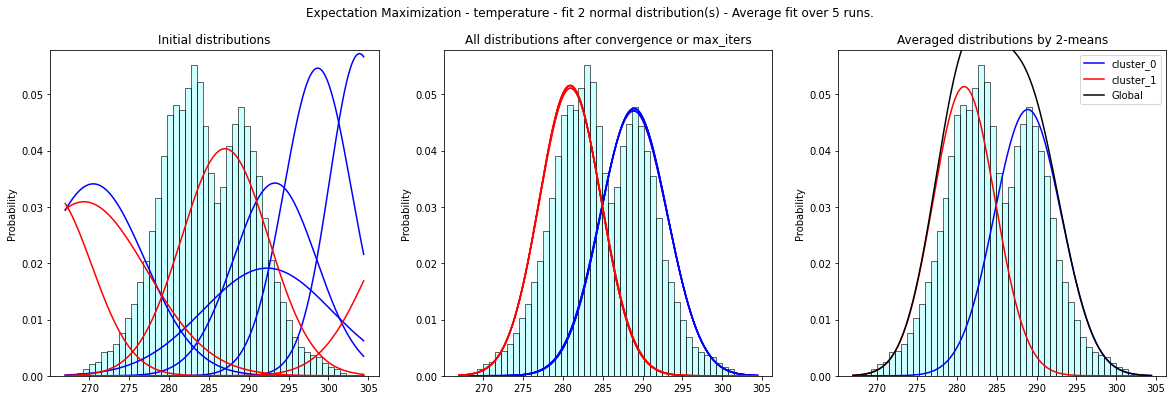

elapsed : 1.53 s.
Initial parameters :
	 - mu :    [310.44 289.11 271.02]
	 - sigma : [5.48 3.06 5.74]
	 - w :     [0.45 0.29 0.26]

Run number 0 over 5.
Initial parameters :
	 - mu :    [290.35 253.92 282.64]
	 - sigma : [5.69 5.08 6.04]
	 - w :     [0.27 0.45 0.28]
  5 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [290.32888063 280.64527512 283.68868745]
	sigma : [3.69096065 4.05577045 4.21998928]
	w :     [0.33461749 0.3327803  0.33260221]

Run number 1 over 5.
Initial parameters :
	 - mu :    [314.11 314.9  270.94]
	 - sigma : [6.74 2.78 5.66]
	 - w :     [0.3  0.23 0.47]
  5 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [283.7462401  290.32541539 280.5830085 ]
	sigma : [4.19014582 3.69007377 4.0367517 ]
	w :     [0.33262291 0.33454516 0.33283193]

Run number 2 over 5.
Initial parameters :
	 - mu :    [285.03 311.55 330.81]
	 - sigma : [5.25 3.37 6.63]
	 - w :     [0.23 0.41 0.36]
  9 %

Threshold reached, less than 0.

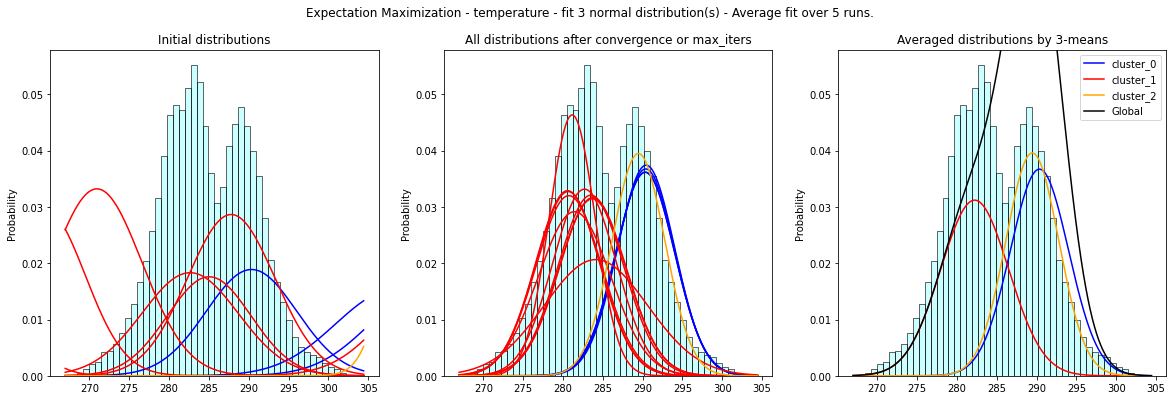

elapsed : 3.90 s.
Initial parameters :
	 - mu :    [307.04 305.3  273.69 296.09]
	 - sigma : [8.09 6.94 8.23 5.65]
	 - w :     [0.26 0.23 0.27 0.23]

Run number 0 over 5.
Initial parameters :
	 - mu :    [240.94 265.31 305.96 303.57]
	 - sigma : [3.88 4.95 3.89 7.03]
	 - w :     [0.23 0.24 0.26 0.26]
  9 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [279.06951065 282.21945983 289.11660532 289.33837629]
	sigma : [3.7661455  2.19393902 5.0648865  2.45477095]
	w :     [0.25209136 0.25308039 0.248777   0.24605124]

Run number 1 over 5.
Initial parameters :
	 - mu :    [271.03 312.87 266.48 319.29]
	 - sigma : [4.85 5.44 6.94 5.31]
	 - w :     [0.17 0.28 0.26 0.3 ]
  3 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [279.2350425  289.46203079 282.2000606  288.82898797]
	sigma : [3.87466021 2.42264323 2.26446735 5.25315157]
	w :     [0.25185653 0.24616939 0.25248576 0.24948832]

Run number 2 over 5.
Initial parameters :
	 - mu :  

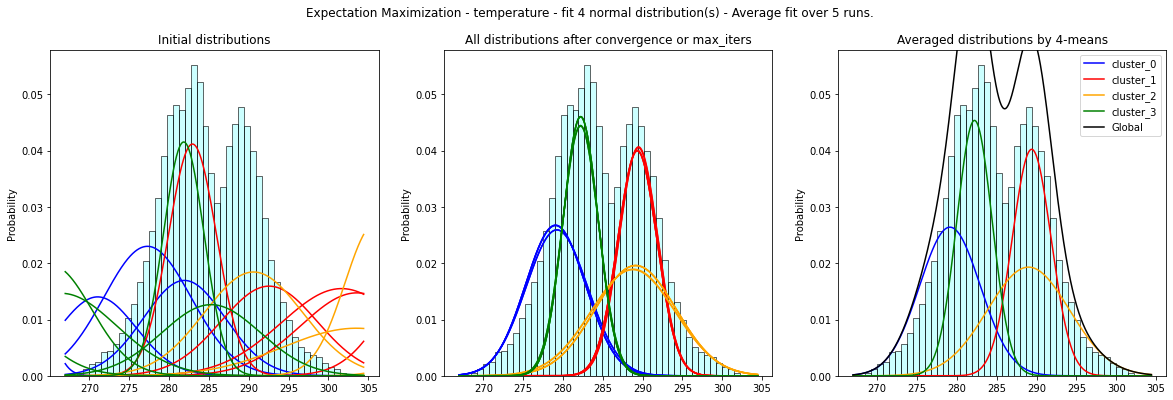

elapsed : 5.82 s.



	 humidity



Initial parameters :
	 - mu :    [128.89  67.61]
	 - sigma : [ 5.76 12.27]
	 - w :     [0.36 0.64]

Run number 0 over 5.
Initial parameters :
	 - mu :    [90.19 76.89]
	 - sigma : [9.58 8.44]
	 - w :     [0.46 0.54]
  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [86.50024911 75.3461635 ]
	sigma : [6.25220898 9.50358334]
	w :     [0.50040955 0.49959045]

Run number 1 over 5.
Initial parameters :
	 - mu :    [97.44 49.03]
	 - sigma : [13.08 10.19]
	 - w :     [0.43 0.57]
  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [86.61978013 75.22479075]
	sigma : [6.19485707 9.39911763]
	w :     [0.5001242 0.4998758]

Run number 2 over 5.
Initial parameters :
	 - mu :    [50.36 75.73]
	 - sigma : [7.17 8.  ]
	 - w :     [0.53 0.47]
  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [75.23069835 86.61321873]
	sigma : [9.40802936 6.19388858]
	w :     [0.49983312 0.500

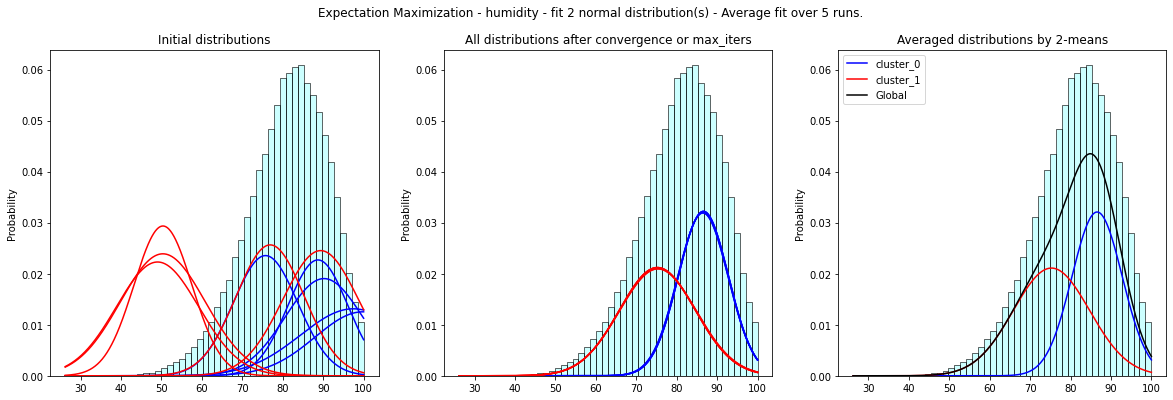

elapsed : 1.28 s.
Initial parameters :
	 - mu :    [ 61.71 125.3   91.79]
	 - sigma : [ 9.5   9.2  13.23]
	 - w :     [0.33 0.38 0.29]

Run number 0 over 5.
Initial parameters :
	 - mu :    [102.05 104.59  86.44]
	 - sigma : [8.83 8.04 9.63]
	 - w :     [0.4  0.22 0.38]
  7 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [80.31250528 89.9903389  72.5282582 ]
	sigma : [5.22917864 4.69538234 9.22642662]
	w :     [0.33452357 0.33167037 0.33380607]

Run number 1 over 5.
Initial parameters :
	 - mu :    [ 89.8  108.79  83.36]
	 - sigma : [10.56  7.    8.42]
	 - w :     [0.37 0.33 0.3 ]
  9 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [72.54497614 90.00403011 80.30782233]
	sigma : [9.23600777 4.69003383 5.23237887]
	w :     [0.333793   0.33166774 0.33453926]

Run number 2 over 5.
Initial parameters :
	 - mu :    [97.04 47.89 98.  ]
	 - sigma : [10.86 11.38 11.35]
	 - w :     [0.3  0.42 0.28]
  1 %

Threshold reached, less than 0.

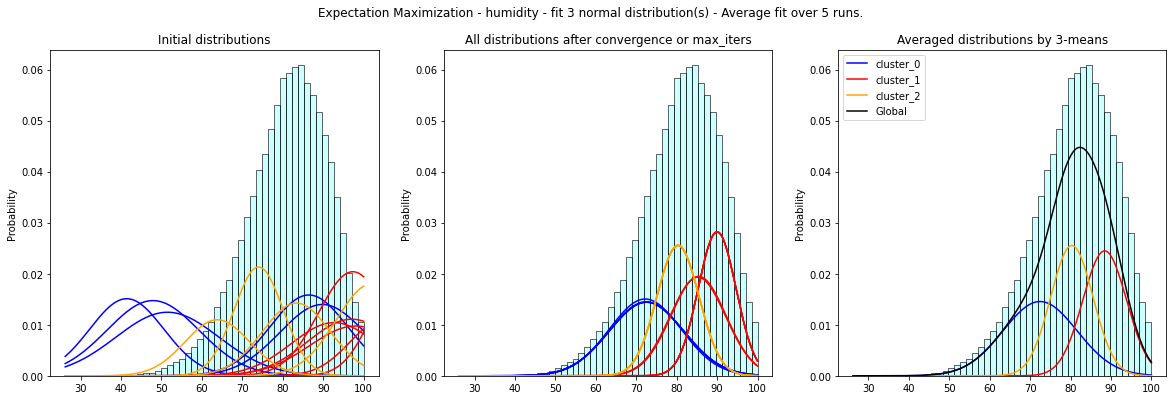

elapsed : 2.79 s.
Initial parameters :
	 - mu :    [109.38  76.25  86.38  71.2 ]
	 - sigma : [8.9  8.86 6.45 9.51]
	 - w :     [0.29 0.23 0.25 0.23]

Run number 0 over 5.
Initial parameters :
	 - mu :    [71.93 99.54 66.18 92.67]
	 - sigma : [ 8.92  9.93  9.12 10.03]
	 - w :     [0.23 0.2  0.27 0.3 ]
 15 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [77.12136674 91.72059209 71.12947471 83.79238025]
	sigma : [5.61034582 3.90822772 9.28344752 3.91083442]
	w :     [0.25071801 0.24880642 0.2499371  0.25053846]

Run number 1 over 5.
Initial parameters :
	 - mu :    [91.87 68.57 78.82 91.98]
	 - sigma : [12.8  10.58  8.95 10.66]
	 - w :     [0.21 0.24 0.29 0.26]
 18 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [83.79244338 71.1187473  77.12258075 91.72064168]
	sigma : [3.92281552 9.28678023 5.61673754 3.90828424]
	w :     [0.25053585 0.24994181 0.25070105 0.24882129]

Run number 2 over 5.
Initial parameters :
	 - mu :    [ 85.9

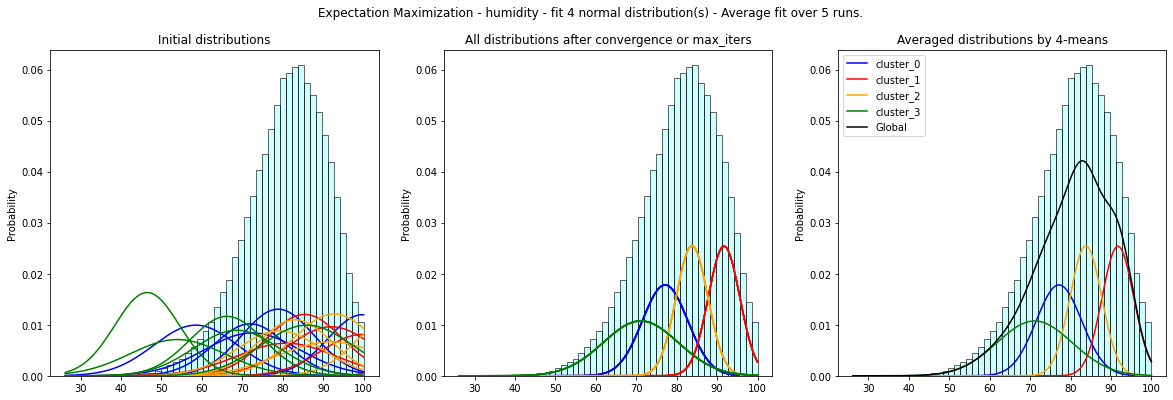

elapsed : 9.01 s.



	 dew_point



Initial parameters :
	 - mu :    [282.98 308.2 ]
	 - sigma : [5.02 4.96]
	 - w :     [0.55 0.45]

Run number 0 over 5.
Initial parameters :
	 - mu :    [279.61 279.24]
	 - sigma : [2.84 3.53]
	 - w :     [0.48 0.52]
  5 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [285.19201388 277.73663443]
	sigma : [2.89527569 3.7444499 ]
	w :     [0.4866643 0.5133357]

Run number 1 over 5.
Initial parameters :
	 - mu :    [275.11 283.13]
	 - sigma : [4.79 4.02]
	 - w :     [0.32 0.68]
  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [277.73852722 285.19315859]
	sigma : [3.74494276 2.89597525]
	w :     [0.51339013 0.48660987]

Run number 2 over 5.
Initial parameters :
	 - mu :    [255.64 292.69]
	 - sigma : [9.43 2.64]
	 - w :     [0.53 0.47]
  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [277.73497418 285.2103723 ]
	sigma : [3.73057072 2.88008875]
	w :     [0.51450

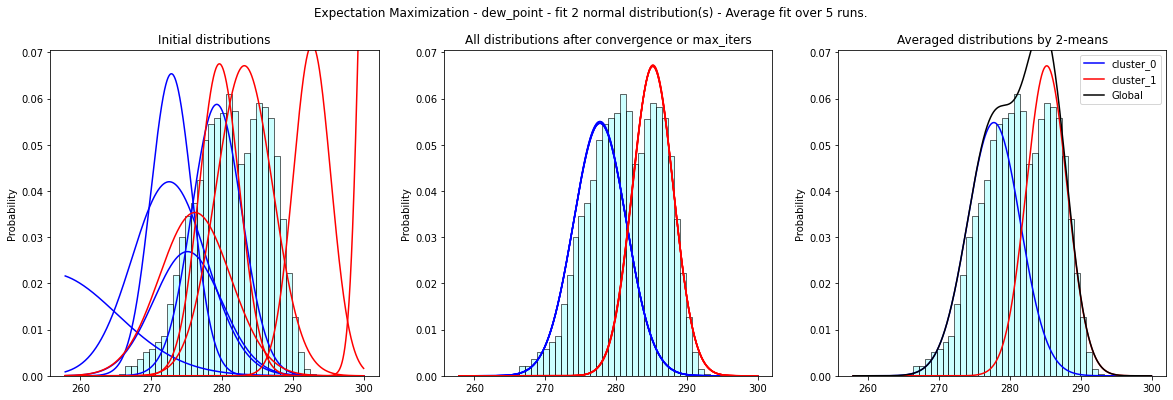

elapsed : 1.64 s.
Initial parameters :
	 - mu :    [280.57 304.02 298.02]
	 - sigma : [5.84 8.36 3.04]
	 - w :     [0.33 0.3  0.36]

Run number 0 over 5.
Initial parameters :
	 - mu :    [286.69 231.2  311.28]
	 - sigma : [3.92 5.36 4.82]
	 - w :     [0.31 0.35 0.34]
  4 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [280.74392458 276.81814418 286.56071456]
	sigma : [2.83364446 3.88708963 2.07870582]
	w :     [0.33393159 0.33409698 0.33197143]

Run number 1 over 5.
Initial parameters :
	 - mu :    [289.39 281.66 264.66]
	 - sigma : [3.89 2.56 5.85]
	 - w :     [0.32 0.41 0.27]
  4 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [286.56258922 280.74691155 276.82164129]
	sigma : [2.07730846 2.83452284 3.88603313]
	w :     [0.33204917 0.3338937  0.33405712]

Run number 2 over 5.
Initial parameters :
	 - mu :    [268.36 282.37 261.8 ]
	 - sigma : [5.24 4.86 4.28]
	 - w :     [0.3  0.33 0.37]
  1 %

Threshold reached, less than 0.

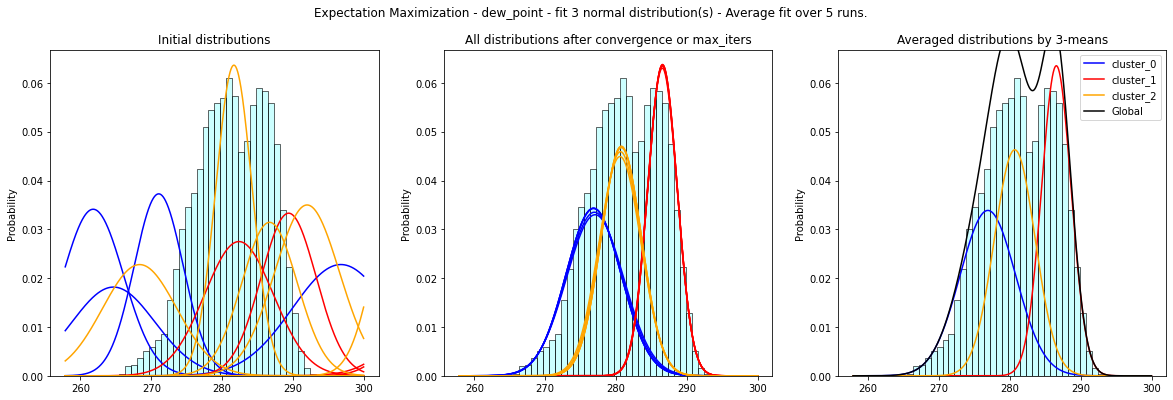

elapsed : 2.43 s.
Initial parameters :
	 - mu :    [281.27 295.05 278.52 282.69]
	 - sigma : [7.71 1.48 4.8  4.96]
	 - w :     [0.19 0.26 0.22 0.33]

Run number 0 over 5.
Initial parameters :
	 - mu :    [265.23 284.11 302.24 312.66]
	 - sigma : [10.35  5.15  4.09  7.06]
	 - w :     [0.27 0.23 0.27 0.24]
  9 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [276.27287387 279.05854593 286.95119335 283.17037724]
	sigma : [3.90894627 2.83838215 1.92554298 2.81447691]
	w :     [0.24982258 0.25005932 0.25025873 0.24985937]

Run number 1 over 5.
Initial parameters :
	 - mu :    [291.24 249.85 304.47 274.95]
	 - sigma : [7.59 6.2  8.54 3.69]
	 - w :     [0.32 0.21 0.24 0.23]
  8 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [283.16126376 276.22422463 286.92825966 279.14704573]
	sigma : [2.87947323 3.86416319 1.93034171 2.85022938]
	w :     [0.2498481  0.24980877 0.25024738 0.25009576]

Run number 2 over 5.
Initial parameters :
	 - mu

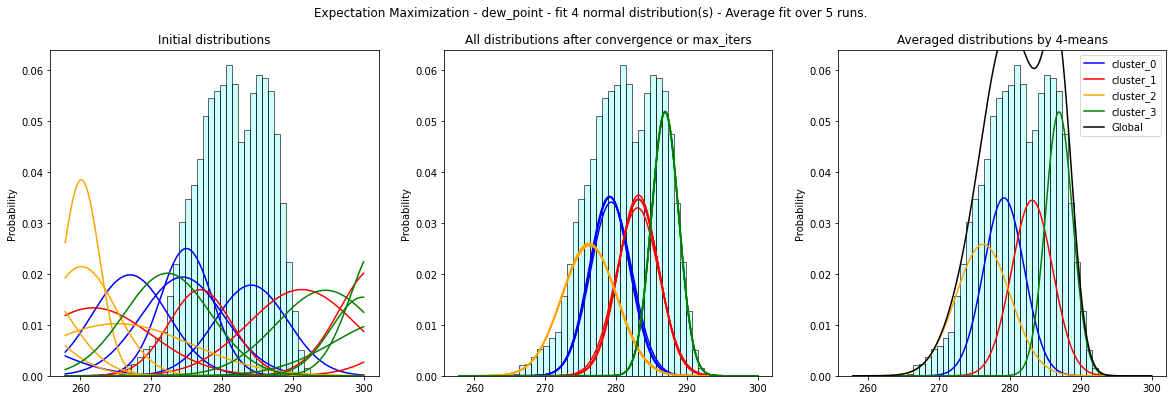

elapsed : 6.13 s.



	 current_precipitations



Initial parameters :
	 - mu :    [17.12  5.28]
	 - sigma : [2.31 3.63]
	 - w :     [0.55 0.45]

Run number 0 over 5.
Initial parameters :
	 - mu :    [-31.01  -3.84]
	 - sigma : [5.01 2.81]
	 - w :     [0.52 0.48]
  2 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [4.65795935 0.06996538]
	sigma : [5.52189504 0.11015282]
	w :     [0.41271736 0.58728264]

Run number 1 over 5.
Initial parameters :
	 - mu :    [-18.99   0.39]
	 - sigma : [6.49 5.67]
	 - w :     [0.53 0.47]
  2 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [0.06935425 4.64087648]
	sigma : [0.10933485 5.51157791]
	w :     [0.58652303 0.41347697]

Run number 2 over 5.
Initial parameters :
	 - mu :    [-8.78  6.2 ]
	 - sigma : [4.05 5.16]
	 - w :     [0.5 0.5]
  2 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [0.07046385 4.65854905]
	sigma : [0.11072146 5.51423283]
	w :     [0.58799493

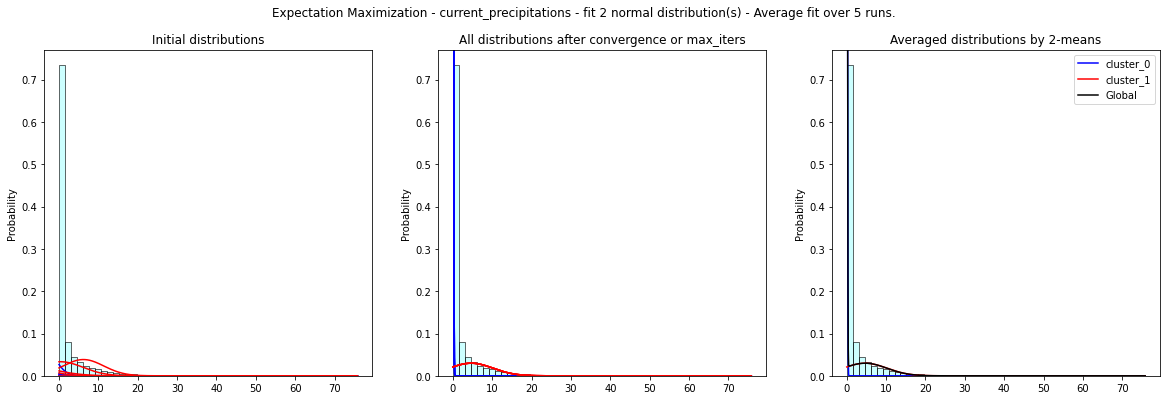

elapsed : 1.41 s.
Initial parameters :
	 - mu :    [53.83  9.45  5.02]
	 - sigma : [7.29 6.17 4.86]
	 - w :     [0.32 0.35 0.33]

Run number 0 over 5.
Initial parameters :
	 - mu :    [ 42.29 -13.49   8.78]
	 - sigma : [3.02 4.99 4.94]
	 - w :     [0.32 0.34 0.35]


Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [5.40392281 0.         0.28636631]
	sigma : [5.67561184e+00 1.00000000e-05 1.39238323e-01]
	w :     [0.35037991 0.4109658  0.23865429]

Run number 1 over 5.
Initial parameters :
	 - mu :    [  2.2   22.57 -35.67]
	 - sigma : [6.53 4.96 1.77]
	 - w :     [0.35 0.31 0.34]


Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [0.28666681 5.40629064 0.        ]
	sigma : [1.39578768e-01 5.67957178e+00 1.00000000e-05]
	w :     [0.23868004 0.35041278 0.41090718]

Run number 2 over 5.
Initial parameters :
	 - mu :    [  1.52   9.54 -20.45]
	 - sigma : [4.91 1.74 0.39]
	 - w :     [0.31 0.39 0.3 ]
 99 %

100 %
Final parameters :
	mu :  

Traceback (most recent call last):
  File "/tmp/ipykernel_458073/886430121.py", line 9, in <module>
    em.average_fit(runs=5, max_iters=1000, plot=True,
  File "/tmp/ipykernel_458073/1380443488.py", line 169, in average_fit
    history_record["cluster"] = kmeans.fit_predict(history_record_scaled)
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py", line 1258, in fit_predict
    return self.fit(X, sample_weight=sample_weight).labels_
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py", line 1140, in fit
    X = self._validate_data(
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/base.py", line 561, in _validate_data
    X = check_array(X, **check_params)
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/utils/validation.py", line 792, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/util

 99 %

100 %
Final parameters :
	mu :    [nan nan nan nan]
	sigma : [nan nan nan nan]
	w :     [nan nan nan nan]

Run number 1 over 5.
Initial parameters :
	 - mu :    [11.63 18.28  3.07 -9.59]
	 - sigma : [2.04 4.8  0.28 3.53]
	 - w :     [0.22 0.3  0.17 0.31]


Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [1.56766891 8.45793873 0.23784072 0.        ]
	sigma : [9.83417699e-01 6.21991572e+00 7.83678661e-02 1.00000000e-05]
	w :     [0.20364686 0.18866772 0.1967996  0.41088582]

Run number 2 over 5.
Initial parameters :
	 - mu :    [-28.75  10.53 -22.94  32.7 ]
	 - sigma : [0.8  2.53 3.74 0.93]
	 - w :     [0.19 0.3  0.26 0.25]


Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [0.         1.56775981 0.2379536  8.46272588]
	sigma : [1.00000000e-05 9.83766640e-01 7.84584085e-02 6.22794947e+00]
	w :     [0.41088582 0.20374981 0.19677021 0.18859417]

Run number 3 over 5.
Initial parameters :
	 - mu :    [-17.74  11.32  24.23  22.35]
	 

Traceback (most recent call last):
  File "/tmp/ipykernel_458073/886430121.py", line 9, in <module>
    em.average_fit(runs=5, max_iters=1000, plot=True,
  File "/tmp/ipykernel_458073/1380443488.py", line 169, in average_fit
    history_record["cluster"] = kmeans.fit_predict(history_record_scaled)
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py", line 1258, in fit_predict
    return self.fit(X, sample_weight=sample_weight).labels_
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py", line 1140, in fit
    X = self._validate_data(
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/base.py", line 561, in _validate_data
    X = check_array(X, **check_params)
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/utils/validation.py", line 792, in check_array
    _assert_all_finite(array, allow_nan=force_all_finite == "allow-nan")
  File "/home/legmint/.local/lib/python3.8/site-packages/sklearn/util

In [7]:
for col in ['wind_speed', 'temperature', 'humidity', 'dew_point', 'current_precipitations']:
    print("\n\n", "=" * 50, sep="")
    print("\n\t", col)
    print("\n", "=" * 50, "\n\n", sep="")
    for k in range(2, 5):
        em = EM_1D(x=df[col].to_numpy(), nb_dist=k, split_ratio=0.01, threshold=0.001, talk=True)
        t = time.time()
        try:
            em.average_fit(runs=5, max_iters=1000, plot=True,
                           plot_title="Expectation Maximization - {} - fit {} normal distribution(s) - Average fit over 5 runs.".format(
                               col, k))
        except Exception:
            traceback.print_exc()
        finally:
            print("elapsed : {:.2f} s.".format(time.time() - t))




	 wind_speed



Initial parameters :
	 - mu :    [-19.23]
	 - sigma : [0.08]
	 - w :     [1.]
 99 %

100 %
Final parameters :
	mu :    [nan]
	sigma : [nan]
	w :     [nan]


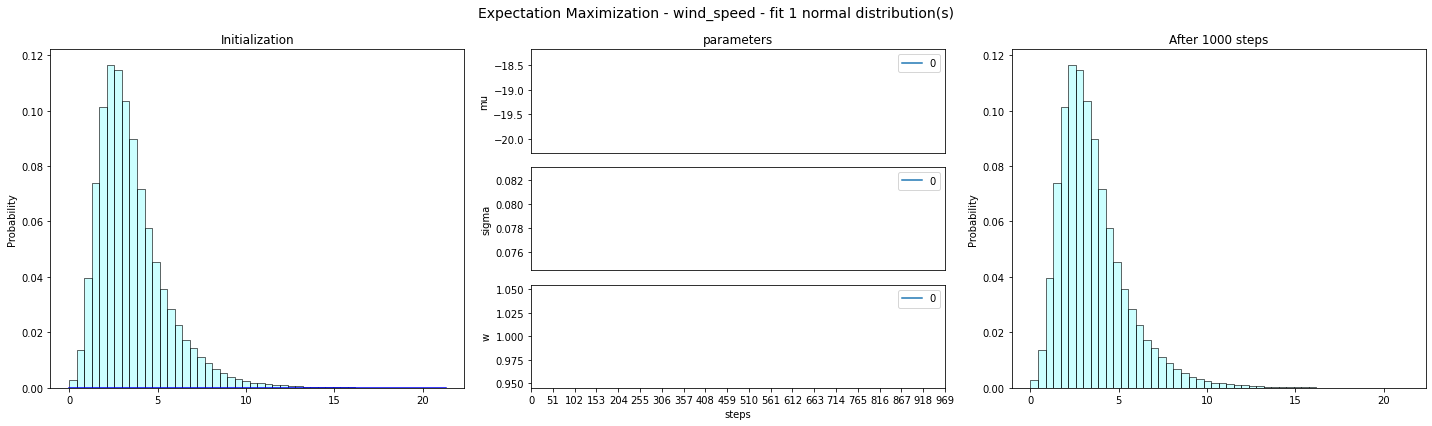

elapsed : 1.95 s.
Initial parameters :
	 - mu :    [1.83 6.9 ]
	 - sigma : [2.64 4.48]
	 - w :     [0.5 0.5]
  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [2.58232397 4.6173987 ]
	sigma : [0.89525608 2.23791306]
	w :     [0.52633382 0.47366618]


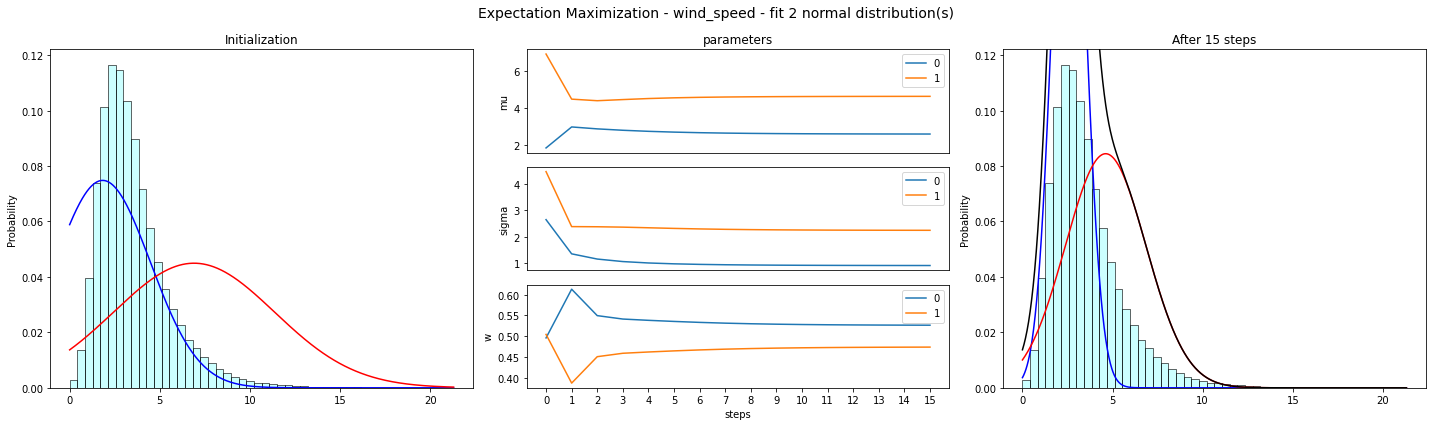

elapsed : 0.90 s.
Initial parameters :
	 - mu :    [24.56 28.16 26.72]
	 - sigma : [0.16 3.97 2.47]
	 - w :     [0.43 0.34 0.23]


Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [21.305834    2.58175761  4.61739175]
	sigma : [1.00000000e-05 8.94428974e-01 2.23539532e+00]
	w :     [1.17198945e-05 5.26154846e-01 4.73833434e-01]


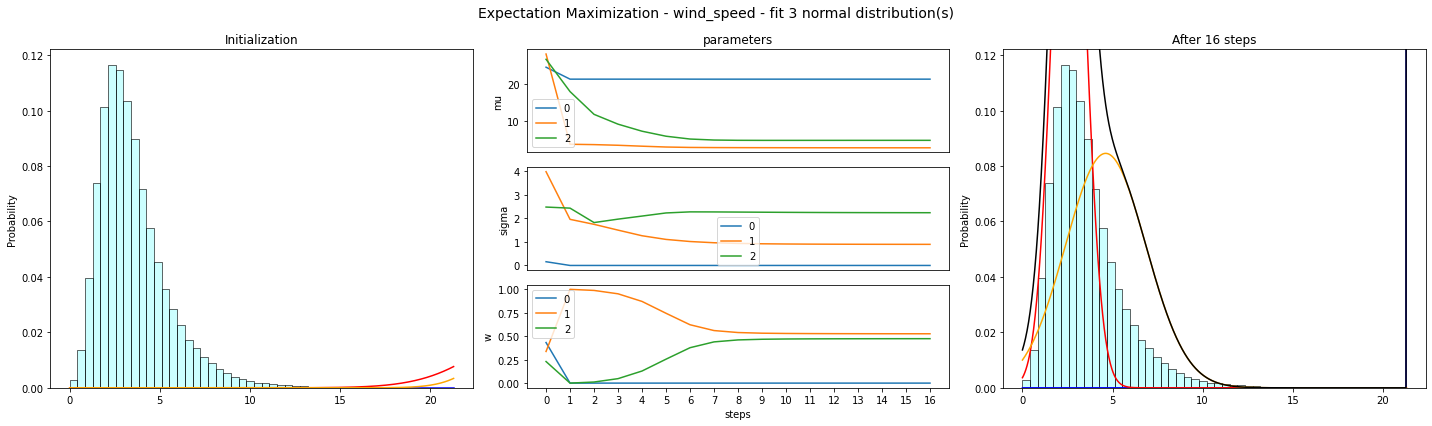

elapsed : 1.19 s.
Initial parameters :
	 - mu :    [-19.17 -19.8   26.36 -25.12]
	 - sigma : [2.87 4.19 2.99 1.53]
	 - w :     [0.31 0.29 0.18 0.22]
  6 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [2.88952423 4.05275133 5.54702286 1.8129607 ]
	sigma : [0.62527423 0.99438824 2.50634905 0.57612453]
	w :     [0.25406831 0.25405788 0.238484   0.25338981]


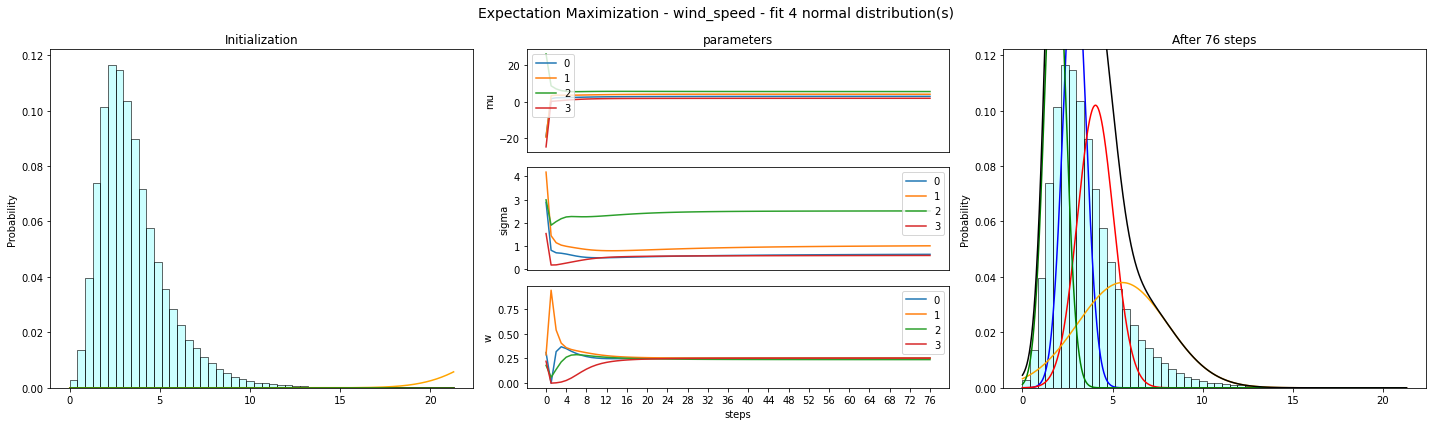

elapsed : 2.33 s.



	 temperature



Initial parameters :
	 - mu :    [310.24]
	 - sigma : [6.75]
	 - w :     [1.]
  0 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [284.89570549]
	sigma : [5.68401003]
	w :     [1.]


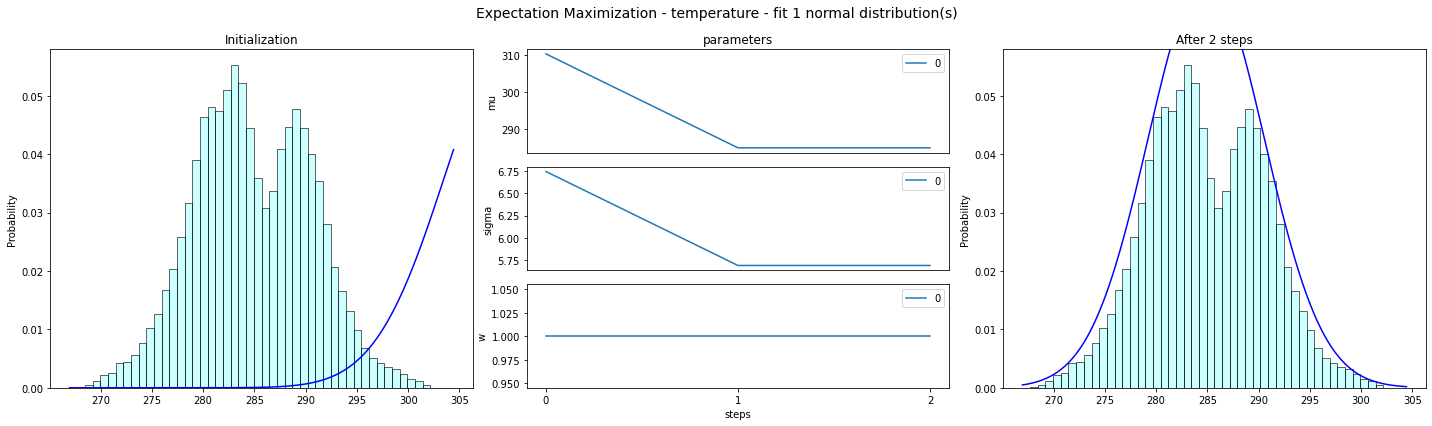

elapsed : 0.73 s.
Initial parameters :
	 - mu :    [271.46 311.16]
	 - sigma : [7.37 5.16]
	 - w :     [0.48 0.52]
  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [280.90826577 288.92227935]
	sigma : [3.8830404  4.17729555]
	w :     [0.50223008 0.49776992]


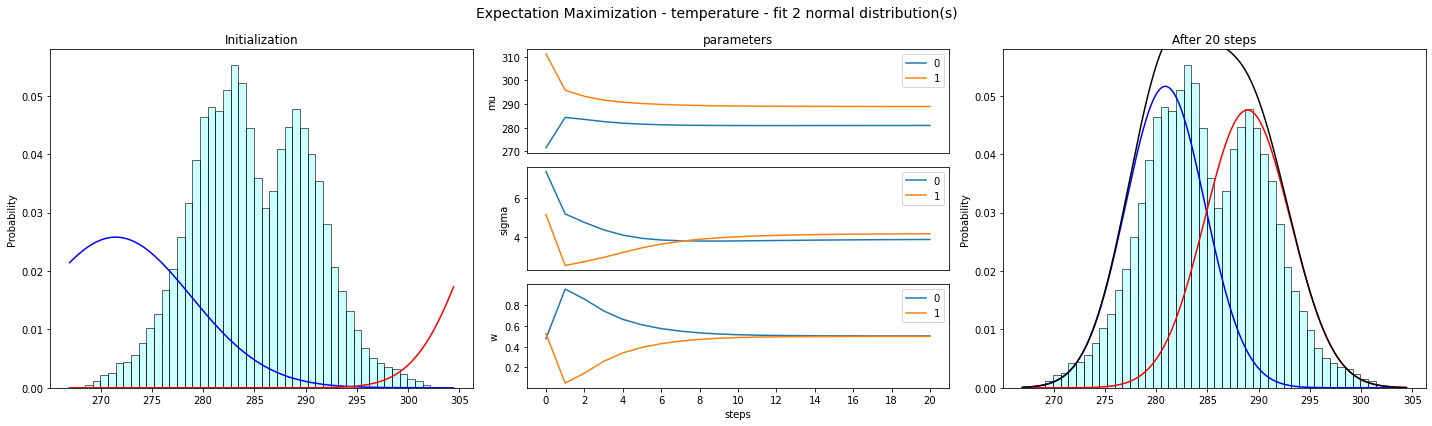

elapsed : 0.82 s.
Initial parameters :
	 - mu :    [251.36 280.83 290.71]
	 - sigma : [3.15 5.3  2.95]
	 - w :     [0.27 0.35 0.38]
  6 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [280.74414639 283.49330492 290.39666782]
	sigma : [4.1601938  4.10658655 3.63918794]
	w :     [0.33223442 0.33228126 0.33548432]


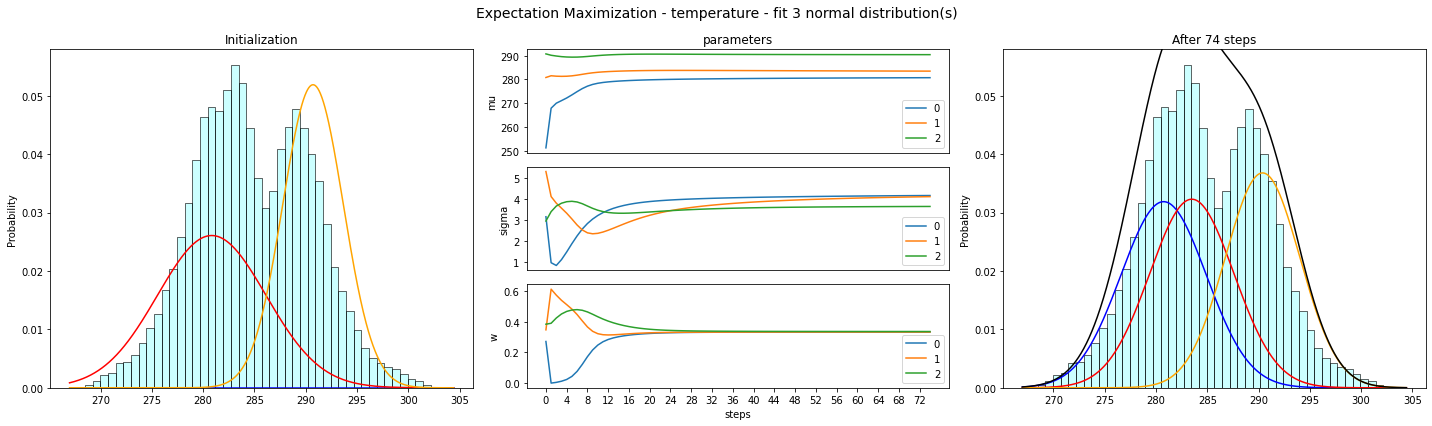

elapsed : 1.48 s.
Initial parameters :
	 - mu :    [277.97 281.47 307.25 327.38]
	 - sigma : [0.85 6.37 7.1  4.89]
	 - w :     [0.29 0.23 0.24 0.24]
  8 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [279.07264217 282.21967995 289.33728208 289.12434617]
	sigma : [3.76155372 2.19727078 2.45220014 5.06137816]
	w :     [0.25211745 0.25307019 0.24604378 0.24876858]


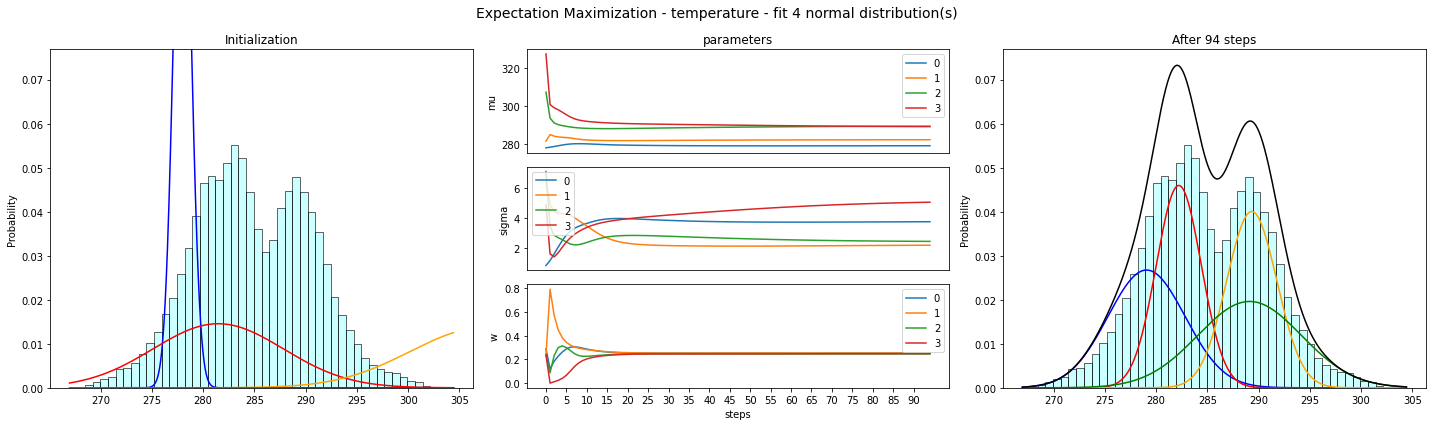

elapsed : 2.03 s.



	 humidity



Initial parameters :
	 - mu :    [79.18]
	 - sigma : [9.88]
	 - w :     [1.]
  0 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [80.92583804]
	sigma : [9.78606093]
	w :     [1.]


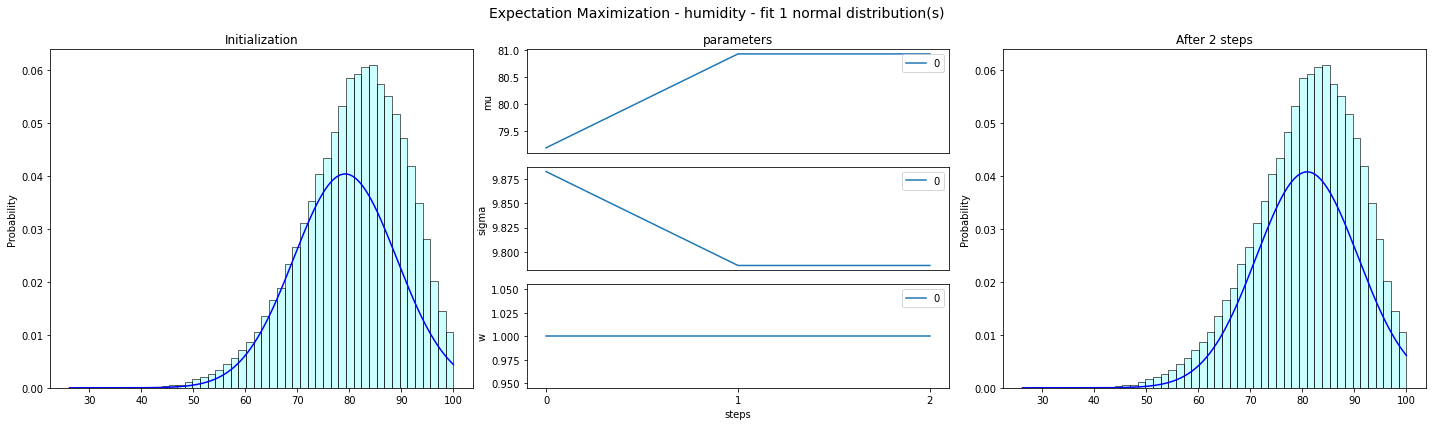

elapsed : 0.84 s.
Initial parameters :
	 - mu :    [86.59 64.64]
	 - sigma : [5.42 8.85]
	 - w :     [0.57 0.43]
  1 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [86.62209684 75.22245447]
	sigma : [6.19336457 9.40246009]
	w :     [0.50012297 0.49987703]


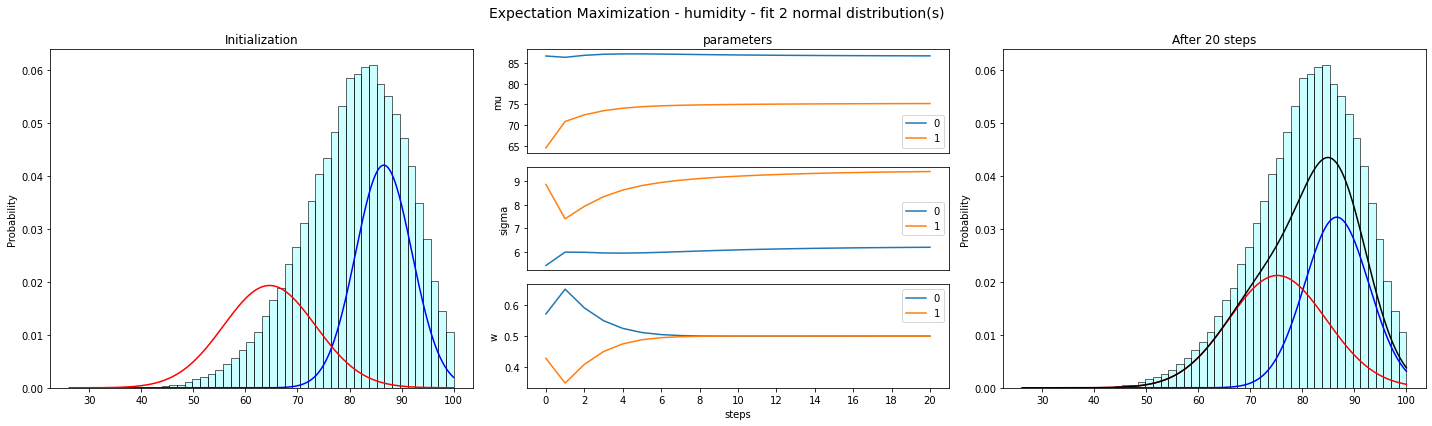

elapsed : 0.87 s.
Initial parameters :
	 - mu :    [91.35 69.81 69.2 ]
	 - sigma : [8.3  9.55 7.65]
	 - w :     [0.26 0.36 0.38]
  8 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [89.97891458 72.57041741 80.28713203]
	sigma : [4.69883252 9.24671102 5.25338723]
	w :     [0.33171813 0.33375019 0.33453168]


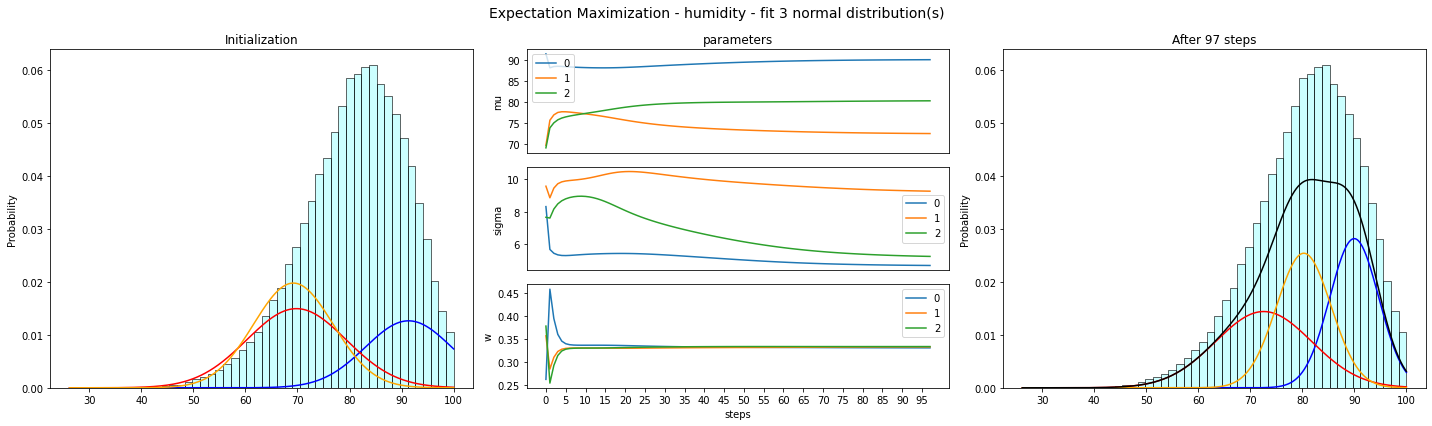

elapsed : 1.56 s.
Initial parameters :
	 - mu :    [ 74.72 109.48 104.64  95.77]
	 - sigma : [11.46 10.72  9.46  9.07]
	 - w :     [0.27 0.3  0.24 0.2 ]
 18 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [71.11943684 83.79190089 91.7163181  77.15055098]
	sigma : [9.27226667 3.93099463 3.91232109 5.6371736 ]
	w :     [0.24995338 0.25051967 0.24880254 0.2507244 ]


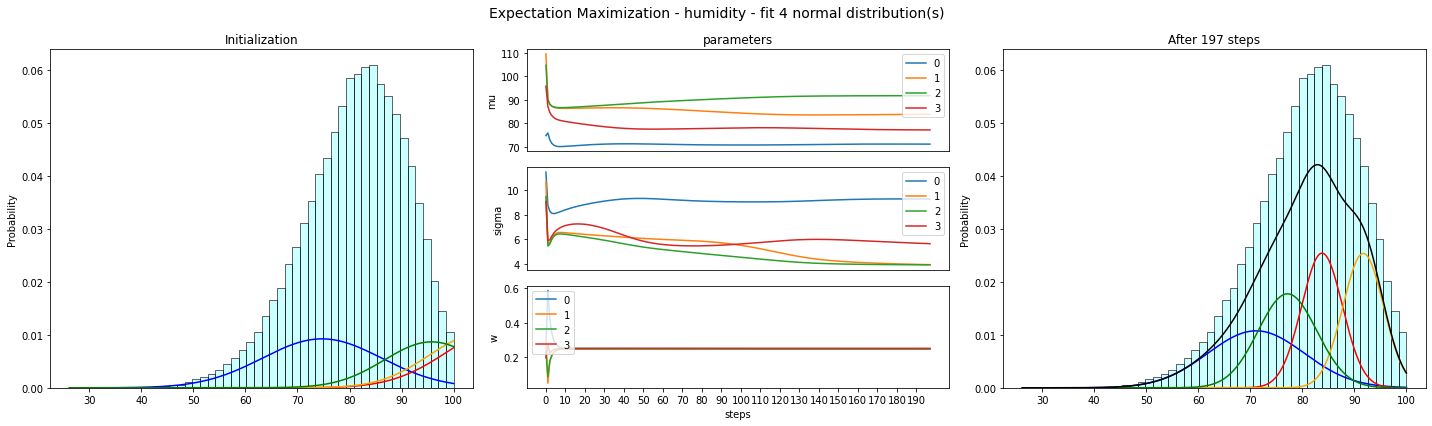

elapsed : 3.19 s.



	 dew_point



Initial parameters :
	 - mu :    [281.86]
	 - sigma : [5.99]
	 - w :     [1.]
  0 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [281.36723984]
	sigma : [5.01632872]
	w :     [1.]


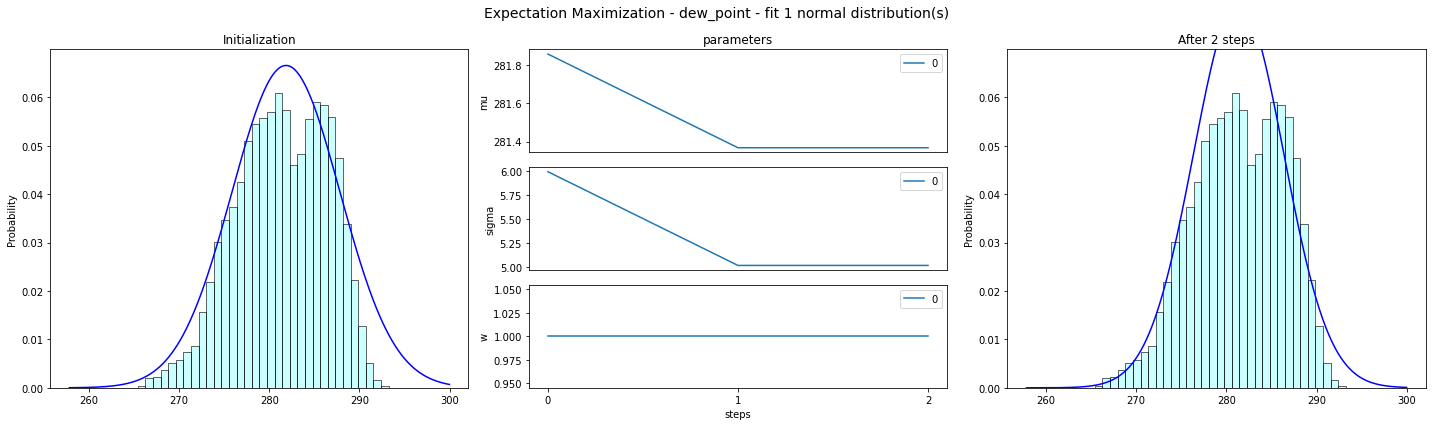

elapsed : 0.70 s.
Initial parameters :
	 - mu :    [280.15 283.55]
	 - sigma : [9.5  4.08]
	 - w :     [0.47 0.53]
  3 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [277.74022085 285.19215895]
	sigma : [3.74489885 2.89751967]
	w :     [0.51327257 0.48672743]


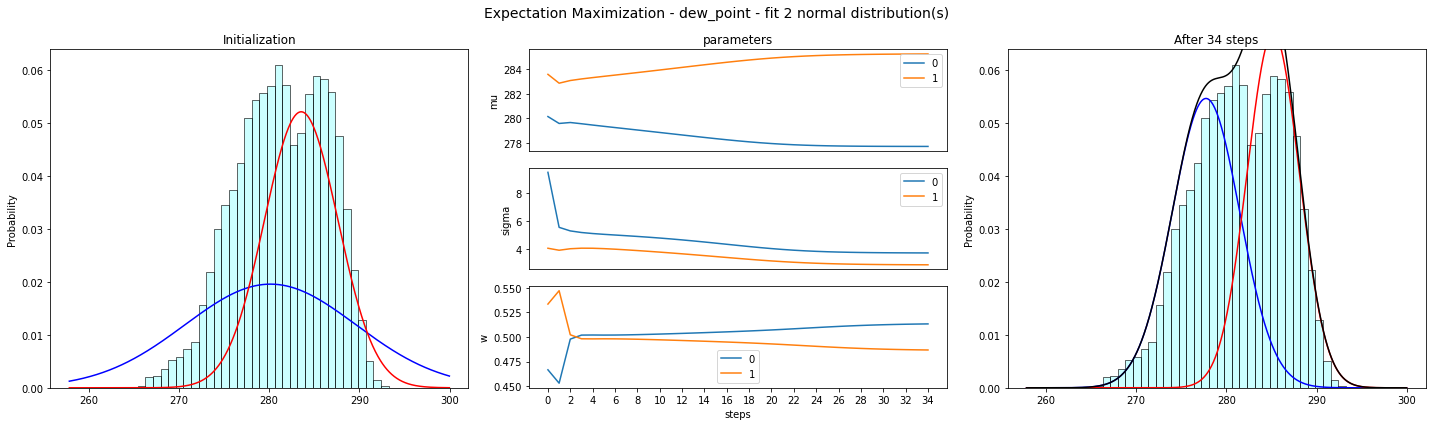

elapsed : 1.05 s.
Initial parameters :
	 - mu :    [293.52 321.98 314.01]
	 - sigma : [2.51 4.86 5.54]
	 - w :     [0.46 0.17 0.38]
  4 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [280.75611272 286.56338781 276.81858615]
	sigma : [2.83381851 2.07958786 3.87856275]
	w :     [0.33391102 0.33200653 0.33408245]


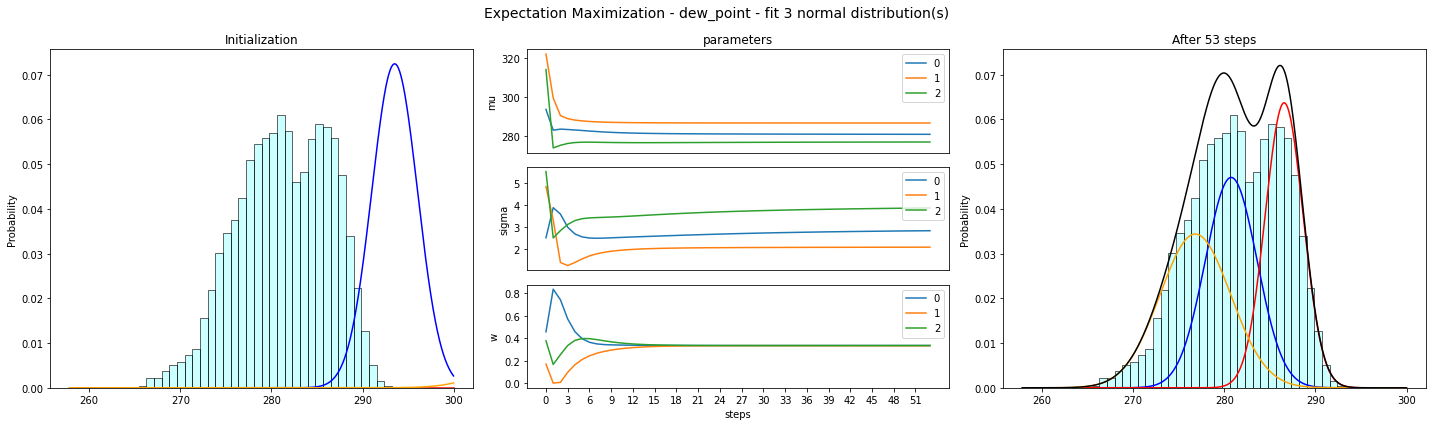

elapsed : 1.25 s.
Initial parameters :
	 - mu :    [283.02 313.11 304.41 275.24]
	 - sigma : [10.    4.49  6.5   5.36]
	 - w :     [0.33 0.2  0.25 0.23]
  5 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [279.12861884 283.15018416 286.92545829 276.24819811]
	sigma : [2.85669013 2.8883809  1.93386215 3.88621885]
	w :     [0.25009413 0.24986156 0.25021953 0.24982478]


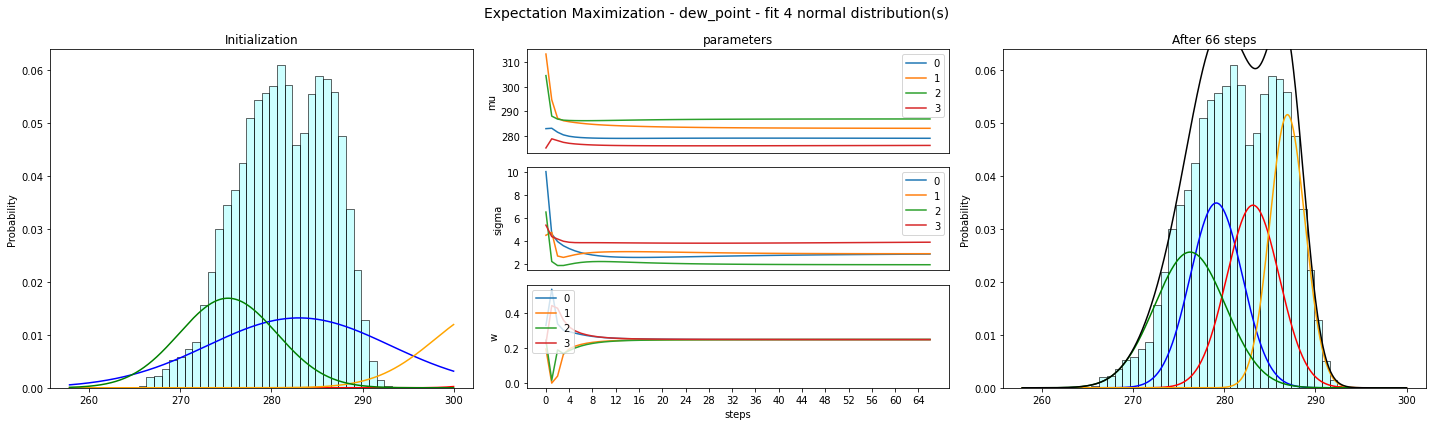

elapsed : 1.66 s.



	 current_precipitations



Initial parameters :
	 - mu :    [23.82]
	 - sigma : [2.41]
	 - w :     [1.]
  0 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [1.95924056]
	sigma : [4.19635559]
	w :     [1.]


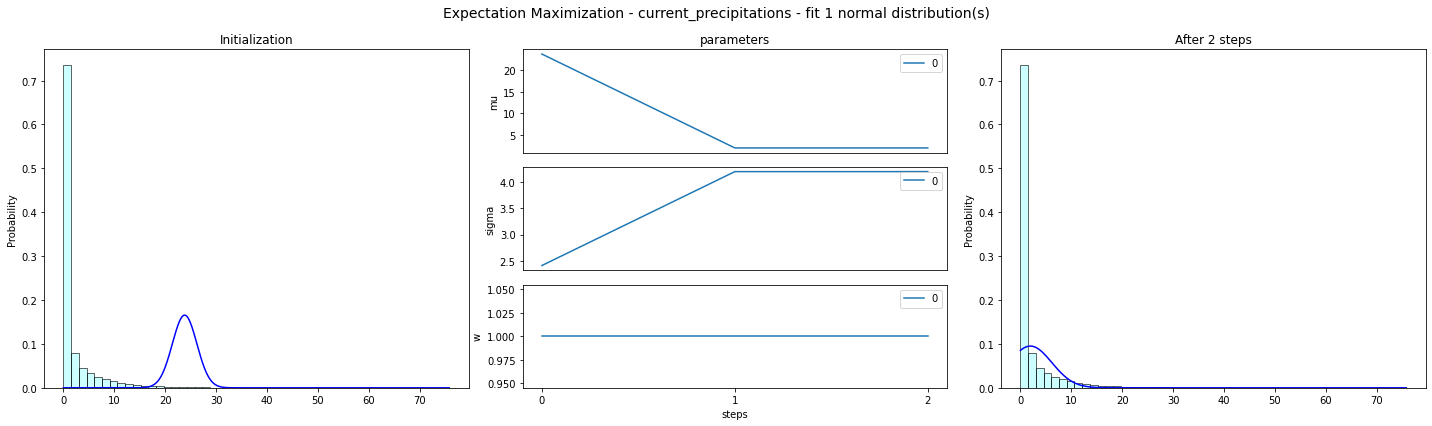

elapsed : 0.72 s.
Initial parameters :
	 - mu :    [ 5.43 10.48]
	 - sigma : [4.71 4.73]
	 - w :     [0.53 0.47]
  2 %

Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [0.07030988 4.65605868]
	sigma : [0.11047689 5.52139933]
	w :     [0.5878713 0.4121287]


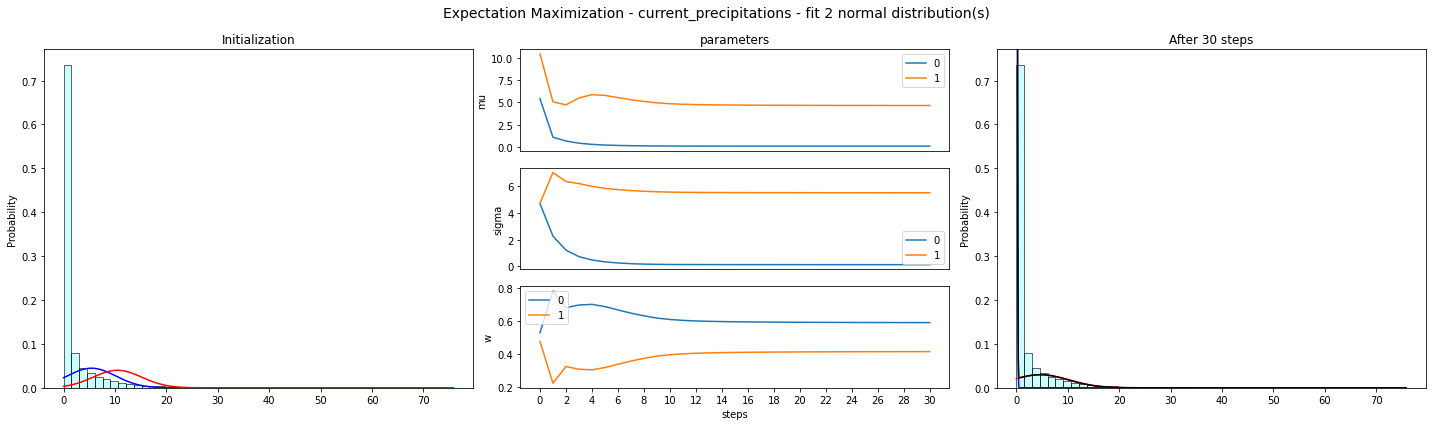

elapsed : 0.92 s.
Initial parameters :
	 - mu :    [ 7.96 20.19  2.71]
	 - sigma : [6.42 1.79 7.97]
	 - w :     [0.33 0.41 0.26]


Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [0.28662271 5.40760015 0.        ]
	sigma : [1.39632439e-01 5.67420864e+00 1.00000000e-05]
	w :     [0.23862767 0.35040655 0.41096578]


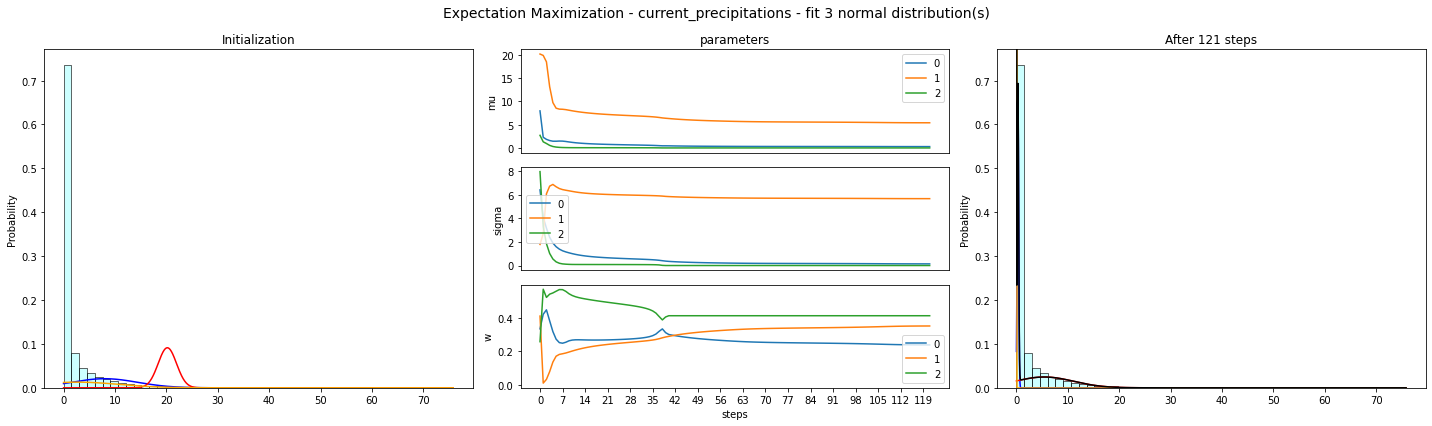

elapsed : 1.76 s.
Initial parameters :
	 - mu :    [ -2.39  26.49 -16.2   20.33]
	 - sigma : [1.43 2.28 4.14 2.5 ]
	 - w :     [0.28 0.31 0.2  0.2 ]


Threshold reached, less than 0.1 % difference.
Final parameters :
	mu :    [0.         8.46944716 0.2378965  1.5731499 ]
	sigma : [1.00000000e-05 6.23735017e+00 7.84128661e-02 9.88054292e-01]
	w :     [0.41067487 0.18855408 0.19666076 0.2041103 ]


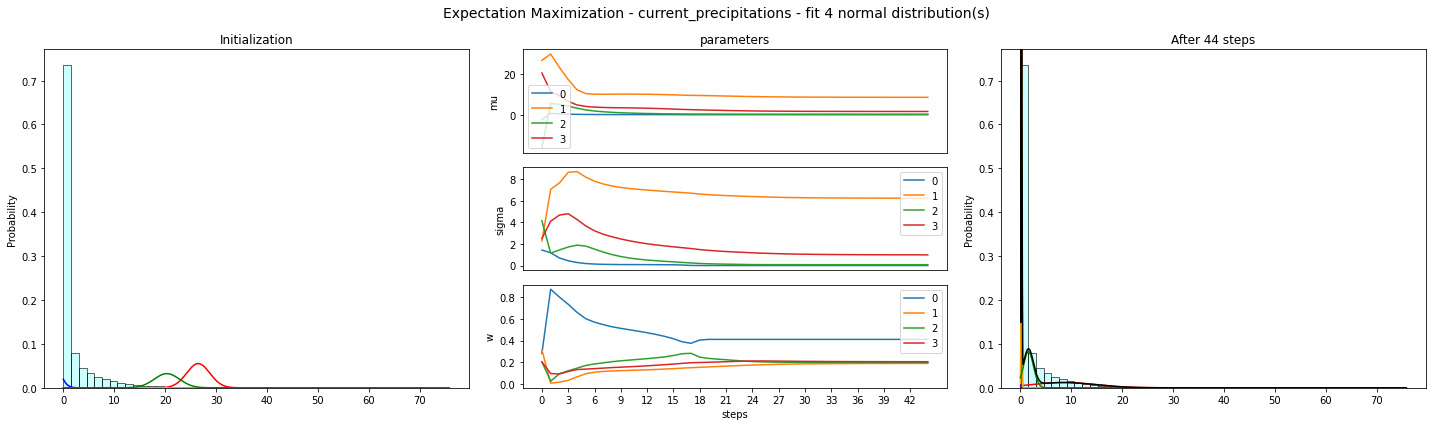

elapsed : 1.50 s.


In [8]:
for col in ['wind_speed', 'temperature', 'humidity', 'dew_point', 'current_precipitations']:
    print("\n\n", "=" * 50, sep="")
    print("\n\t", col)
    print("\n", "=" * 50, "\n\n", sep="")
    for k in range(1, 5):
        em = EM_1D(x=df[col].to_numpy(), nb_dist=k, split_ratio=0.01, threshold=0.001, talk=True)
        t = time.time()
        try :
            em.fit(max_iters=1000)
            em.plot_progression(title="Expectation Maximization - {} - fit {} normal distribution(s)".format(col, k))
        except Exception:
            traceback.print_exc()
        finally:
            print("elapsed : {:.2f} s.".format(time.time() - t))

## 2 dimension

source : https://towardsdatascience.com/implement-expectation-maximization-em-algorithm-in-python-from-scratch-f1278d1b9137

In [112]:
# source : https://github.com/matplotlib/matplotlib/blob/81e8154dbba54ac1607b21b22984cabf7a6598fa/lib/matplotlib/mlab.py#L1866
class EM_2D():
    def __init__(self, x: np.ndarray, nb_dist=2, split_ratio=0.1, threshold=1e-10, minimum_sigma=1e-5, talk=False):
        self.talk = talk  # whether to display information or not
        self.threshold = threshold  # threshold ratio to trigger stop_fitting
        self.minimum_sigma = minimum_sigma  # to avoid sigma being 0
        self.stop_fitting = False  # stop fitting if maximum iterations reached or threshold passed
        self.nb_dist = nb_dist  # number of distributions to fit

        self.split_ratio = split_ratio  # part of x to keep to initialize the parameters
        self.x_all = x  # backup of whole x data
        self.idx_sample = None  # index of x_sample for initialization
        self.x_sample = None  # sample for initialization
        self.x = None  # training part of x
        self.split_x()  # fill x_sample, idx_sample and x

        self.average_by_dist_log_likelihood_record = []  # log_likelihood computed in e_step()
        self.average_log_likelihood_record = []  # log_likelihood computed in e_step()
        self.heuristics = None  # heuristics computed in e_step()

        self.mu = None  # average
        self.sigma = None  # standard deviation
        self.w = None  # weights
        self.init_params()  # initialize the above

        self.history = None  # history
        self.init_history()  # initialize history

        self.r = None  # declare r to anticipate fit()

        self.initial_record = None  # declare variable, used in average_fit()
        self.history_record = None  # declare variable, used in average_fit()
        self.clustered_distributions = None  # declare variable, used in average_fit()

        self.colors = ["blue", "red", "orange", "green", "magenta"]

    def split_x(self):
        self.idx_sample = rng.choice(np.arange(self.x_all.shape[0]),
                                     replace=False,
                                     size=int(self.x_all.shape[0] * self.split_ratio))
        self.x_sample = self.x_all[self.idx_sample]
        self.x = np.delete(self.x_all, self.idx_sample, axis=0)

    def init_params(self):
        mu = []
        for _ in range(self.nb_dist):
            mu.append(np.array(
                [rng.normal(loc=np.mean(self.x_sample[:, 0]),
                            scale=5),
                 rng.normal(loc=np.mean(self.x_sample[:, 1]),
                            scale=5)]))

        sigma = []
        for _ in range(self.nb_dist):
            s = np.zeros(shape=(2, 2))
            s[0, 0] = np.abs(rng.normal(loc=np.sqrt(np.var(self.x_sample[:, 0])),
                                        scale=2))
            s[1, 1] = np.abs(rng.normal(loc=np.sqrt(np.var(self.x_sample[:, 1])),
                                        scale=2))
            sigma.append(s)
        w = np.abs(rng.normal(loc=1,
                              scale=0.2,
                              size=self.nb_dist))
        w /= w.sum()
        if self.talk:
            print("Initial parameters :")
            print("\t - mu :    {}".format(np.round(mu, 2)))
            print("\t - sigma : {}".format(np.round(sigma, 2)))
            print("\t - w :     {}".format(np.round(w, 2)))
        self.mu, self.sigma, self.w = mu, sigma, w

    def init_history(self):
        history = {"mu": [self.mu],
                   "sigma": [self.sigma],
                   "w": [self.w]}
        self.history = history

    def update_h(self):
        self.history["mu"].append(self.mu)
        self.history["sigma"].append(self.sigma)
        self.history["w"].append(self.w)

    def e_step(self):
        np.log([stats.multivariate_normal.pdf(self.x,
                                              self.mu[i],
                                              self.sigma[i])
                for i in range(self.nb_dist)])
        log_p_y_x = np.log([self.w[i] for i in range(self.nb_dist)])[np.newaxis, ...] +\
                    np.log([stats.multivariate_normal.pdf(self.x,
                                                          self.mu[i],
                                                          self.sigma[i])
                            for i in range(self.nb_dist)]).T
        log_p_y_x_norm = logsumexp(log_p_y_x, axis=1)

        self.average_by_dist_log_likelihood_record.append(log_p_y_x.mean(axis=0))
        self.average_log_likelihood_record.append(log_p_y_x_norm.mean())  # log_likelyhood
        self.heuristics = np.exp(log_p_y_x - log_p_y_x_norm[..., np.newaxis])

    def m_step(self):
        total_count = self.x.shape[0]

        sum_heuristic = np.sum(self.heuristics, axis=0)

        w = (sum_heuristic / total_count)
        mu = []
        sigma = []
        for i in range(self.nb_dist):
            mu.append((self.heuristics[:, i][..., np.newaxis].T.dot(self.x) / sum_heuristic[i]).flatten())
            diff = self.x - mu[-1]
            sigma.append(diff.T.dot(diff * self.heuristics[:, i][..., np.newaxis]) / sum_heuristic[i])
            if np.linalg.det(sigma[-1]) == 0:
                print(
                    "WARNING : det(sigma) == 0, add minimum_sigma = {}".format(self.minimum_sigma))
                sigma[-1] += self.minimum_sigma
            if sigma[-1][0,0] == 0:
                print("WARNING : sigma[0,0] == 0, add minimum_sigma = {}".format(self.minimum_sigma))
                sigma[-1][0,0] += self.minimum_sigma
            if sigma[-1][1,1] == 0:
                print("WARNING : sigma[1,1] == 0, add minimum_sigma = {}".format(self.minimum_sigma))
                sigma[-1][1,1] += self.minimum_sigma

        self.w = w
        self.mu = mu
        self.sigma = sigma

    def fit(self, max_iters=100):
        self.stop_fitting = False
        for i in range(max_iters):
            if self.talk and i % int(max_iters // 100 + 1) == 0:
                print("{} %".format(int(i / max_iters * 100)).rjust(5), end="\r")

            self.e_step()
            self.m_step()
            self.update_h()

            if len(self.average_log_likelihood_record) > 2 and\
                    np.abs(self.average_log_likelihood_record[-1] -\
                           self.average_log_likelihood_record[-2]) < self.threshold:
                self.stop_fitting = True
                break

        if self.talk:
            print("\n")
            if self.stop_fitting:
                print("Threshold reached, less than {} % difference.".format(self.threshold * 100))
            else:
                print("100 %")
            print("Final parameters :\n\tmu :    {}\n\tsigma : {}\n\tw :     {}".format(self.history["mu"][-1],
                                                                                        self.history["sigma"][-1],
                                                                                        self.history["w"][-1]))

    def average_fit(self, runs=3, max_iters=100, plot=True, plot_title=""):
        """
        to avoid initialization issues, average over [runs] fit() and different initializations.
        :param plot_title: title of the plot of plot
        :param runs: number of fit() to execute
        :param max_iters: maximum number of iterations for each fit()
        :param plot: plot the final result, average of all fit()

        updates to history to every parameters fo every fit() (for plotting purpose) and parameters to average of every run.
        """
        raise NotImplementedError("not implemented yet.")

    ###########################
    ### POT FUNCTIONS BELOW ###
    ###########################
    def plot_2D(self, cols=("", ""), scatter=False, contour=True, progression=True, height=10,
                title="Expectation Maximization 2D",
                save=False, show=True):
        h = sns.jointplot(x=self.x_all[:, 0],
                          y=self.x_all[:, 1],
                          kind="hex",
                          marginal_kws={"bins": 100},
                          height=height)
        h.set_axis_labels(*cols)
        h.figure.tight_layout()

        if scatter or contour:
            for i in range(self.nb_dist):
                norm = rng.multivariate_normal(self.mu[i], self.sigma[i], size=(2, 10000))[0]
                if scatter :
                    sns.scatterplot(x=norm[:, 0], y=norm[:, 1], alpha=0.1, color=self.colors[i])
                if contour:
                    (counts, x_bins, y_bins) = np.histogram2d(norm[:, 0], norm[:, 1])
                    plt.contour(gaussian_filter(counts, 0.2),
                                extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
                                colors=self.colors[i],
                                antialiased=True,
                                levels=7)


        if progression:
            line_mu = {i: [] for i in range(self.nb_dist)}
            for i in range(self.nb_dist):
                for j in range(len(self.history["mu"])):
                    line_mu[i].append(self.history["mu"][j][i])
                line_mu[i] = np.array(line_mu[i])
                plt.plot(line_mu[i][:, 0],
                         line_mu[i][:, 1],
                         marker="o",
                         color="magenta",
                         markersize=2,
                         linewidth=1)

        if scatter or contour or progression:
            for i in range(self.nb_dist):
                plt.text(x=self.mu[i][0] - 1,
                         y=self.mu[i][1],
                         s="w:" + str(round(self.w[i], 2)),
                         color=self.colors[i],
                         bbox=dict(facecolor='white', alpha=0.75),
                         )

        plt.title(title, y=.97)
        if save:
            plt.savefig("../../images/2D/" + title.replace(" ", "_") + ".jpg")
        if show:
            plt.show()
        else :
            plt.clf()


    def plot_likelihood(self, figsize=(10, 5), title="likelihood", save=False, show=True):
        plt.figure(figsize=figsize)
        log_likelihood = np.array(self.average_by_dist_log_likelihood_record)
        for i in range(self.nb_dist):
            sns.lineplot(x=np.arange(0, log_likelihood.shape[0]),
                         y=log_likelihood[:, i],
                         color=self.colors[i])
        sns.lineplot(x=np.arange(0, len(self.average_log_likelihood_record)),
                     y=self.average_log_likelihood_record,
                     color="black")
        plt.legend(["distrib. " + str(i) for i in range(self.nb_dist)] + ["Global"])
        plt.xlabel("steps")
        plt.ylabel("log_likelihood")
        plt.title(title)
        if save:
            plt.savefig("../../images/2D/" + title.replace(" ", "_") + ".jpg")
        if show:
            plt.show()
        else :
            plt.clf()

    def plot_original(self, cols=("", ""), title="Original", save=False, show=True):
        h = sns.jointplot(x=self.x_all[:, 0],
                          y=self.x_all[:, 1],
                          kind="hex",
                          marginal_kws={"bins": 100},
                          height=10)
        h.set_axis_labels(*cols)
        h.figure.tight_layout()
        plt.title(title, y=.97)
        if save:
            plt.savefig("../../images/2D/" + title.replace(" ", "_") + ".jpg")
        if show:
            plt.show()
        else :
            plt.clf()

In [113]:
columns = ['wind_speed', 'temperature', 'humidity', 'dew_point', 'current_precipitations']
show = False
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        plot_original = True
        col1 = columns[i]
        col2 = columns[j]
        for k in range(2, 5):
            for run in range(1, 4):
                t=time.time()
                title = f"{run}/Expectation Maximization 2D - {col1} and {col2}"
                em2 = EM_2D(x=df[[col1, col2]].to_numpy(), nb_dist=k)
                if plot_original:
                    #plot original distribution
                    em2.plot_original(title=title + " - original", cols=[col1, col2], save=True, show=False)
                    plot_original = False
                try :
                    #fit
                    em2.fit(max_iters=300)
                    #plot fit
                    em2.plot_2D(title=title + f" - fit {k} normal distributions", cols=[col1, col2], scatter=True,
                                contour=True, progression=True, save=True, show=False)
                    em2.plot_2D(title=title + f" - fit {k} normal distributions - no_scatter_plot", cols=[col1, col2], scatter=False,
                                contour=True, progression=True, save=True, show=False)
                    #plot likelihood
                    em2.plot_likelihood(title=title + f" - fit {k} normal distributions - likelihood", save=True,
                                        show=False)
                except Exception:
                    traceback.print_exc()
                finally:
                    print("elapsed : {:.2f} s.".format(time.time() - t))

elapsed : 6.44 s.
elapsed : 5.01 s.
elapsed : 5.62 s.
elapsed : 9.33 s.
elapsed : 15.06 s.
elapsed : 14.46 s.
elapsed : 20.65 s.
elapsed : 18.32 s.
elapsed : 18.85 s.
elapsed : 4.91 s.
elapsed : 4.32 s.
elapsed : 5.74 s.
elapsed : 16.88 s.
elapsed : 16.58 s.
elapsed : 14.13 s.
elapsed : 18.99 s.
elapsed : 19.59 s.
elapsed : 20.44 s.
elapsed : 7.51 s.
elapsed : 6.24 s.
elapsed : 4.95 s.
elapsed : 12.89 s.
elapsed : 14.48 s.
elapsed : 16.00 s.
elapsed : 0.71 s.


Traceback (most recent call last):
  File "/tmp/ipykernel_391740/2012988958.py", line 19, in <module>
    em2.fit(max_iters=300)
  File "/tmp/ipykernel_391740/1023908046.py", line 132, in fit
    self.e_step()
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in e_step
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in <listcomp>
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 516, in pdf
    psd = _PSD(cov, allow_singular=allow_singular)
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 165, in __init__
    raise np.linalg.LinAlgError('singular matrix')
numpy.linalg.LinAlgError: singular matrix


elapsed : 18.80 s.
elapsed : 18.73 s.
elapsed : 2.44 s.
elapsed : 1.97 s.
elapsed : 2.18 s.


Traceback (most recent call last):
  File "/tmp/ipykernel_391740/2012988958.py", line 19, in <module>
    em2.fit(max_iters=300)
  File "/tmp/ipykernel_391740/1023908046.py", line 132, in fit
    self.e_step()
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in e_step
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in <listcomp>
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 516, in pdf
    psd = _PSD(cov, allow_singular=allow_singular)
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 165, in __init__
    raise np.linalg.LinAlgError('singular matrix')
numpy.linalg.LinAlgError: singular matrix
Traceback (most recent call last):
  File "/tmp/ipykernel_391740/2012988958.py", line 19, in <module>
    em2.fit(max_iters=300)
  File "/tmp/ipykernel_391740/1023908046.py", line 132, in fit
    s

elapsed : 0.37 s.
elapsed : 0.05 s.


Traceback (most recent call last):
  File "/tmp/ipykernel_391740/2012988958.py", line 19, in <module>
    em2.fit(max_iters=300)
  File "/tmp/ipykernel_391740/1023908046.py", line 132, in fit
    self.e_step()
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in e_step
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in <listcomp>
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 516, in pdf
    psd = _PSD(cov, allow_singular=allow_singular)
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 165, in __init__
    raise np.linalg.LinAlgError('singular matrix')
numpy.linalg.LinAlgError: singular matrix


elapsed : 0.64 s.
elapsed : 19.53 s.
elapsed : 1.59 s.


Traceback (most recent call last):
  File "/tmp/ipykernel_391740/2012988958.py", line 19, in <module>
    em2.fit(max_iters=300)
  File "/tmp/ipykernel_391740/1023908046.py", line 132, in fit
    self.e_step()
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in e_step
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in <listcomp>
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 516, in pdf
    psd = _PSD(cov, allow_singular=allow_singular)
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 165, in __init__
    raise np.linalg.LinAlgError('singular matrix')
numpy.linalg.LinAlgError: singular matrix


elapsed : 19.11 s.
elapsed : 10.36 s.
elapsed : 9.95 s.
elapsed : 10.24 s.
elapsed : 14.25 s.
elapsed : 14.51 s.
elapsed : 14.24 s.
elapsed : 18.56 s.
elapsed : 18.68 s.
elapsed : 18.45 s.
elapsed : 5.08 s.
elapsed : 6.63 s.
elapsed : 7.13 s.
elapsed : 11.27 s.
elapsed : 13.17 s.
elapsed : 13.82 s.
elapsed : 18.40 s.
elapsed : 18.58 s.
elapsed : 17.21 s.


Traceback (most recent call last):
  File "/tmp/ipykernel_391740/2012988958.py", line 19, in <module>
    em2.fit(max_iters=300)
  File "/tmp/ipykernel_391740/1023908046.py", line 132, in fit
    self.e_step()
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in e_step
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in <listcomp>
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 516, in pdf
    psd = _PSD(cov, allow_singular=allow_singular)
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 158, in __init__
    s, u = scipy.linalg.eigh(M, lower=lower, check_finite=check_finite)
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/linalg/decomp.py", line 445, in eigh
    a1 = _asarray_validated(a, check_finite=check_finite)
  File "/home/legmint/.local/lib/python3.8/site-packages/sci

elapsed : 0.48 s.
elapsed : 2.31 s.
elapsed : 0.03 s.


Traceback (most recent call last):
  File "/tmp/ipykernel_391740/2012988958.py", line 19, in <module>
    em2.fit(max_iters=300)
  File "/tmp/ipykernel_391740/1023908046.py", line 132, in fit
    self.e_step()
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in e_step
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in <listcomp>
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 516, in pdf
    psd = _PSD(cov, allow_singular=allow_singular)
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 158, in __init__
    s, u = scipy.linalg.eigh(M, lower=lower, check_finite=check_finite)
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/linalg/decomp.py", line 445, in eigh
    a1 = _asarray_validated(a, check_finite=check_finite)
  File "/home/legmint/.local/lib/python3.8/site-packages/sci

elapsed : 6.63 s.


Traceback (most recent call last):
  File "/tmp/ipykernel_391740/2012988958.py", line 19, in <module>
    em2.fit(max_iters=300)
  File "/tmp/ipykernel_391740/1023908046.py", line 132, in fit
    self.e_step()
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in e_step
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in <listcomp>
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 516, in pdf
    psd = _PSD(cov, allow_singular=allow_singular)
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 165, in __init__
    raise np.linalg.LinAlgError('singular matrix')
numpy.linalg.LinAlgError: singular matrix


elapsed : 0.92 s.
elapsed : 5.29 s.


Traceback (most recent call last):
  File "/tmp/ipykernel_391740/2012988958.py", line 19, in <module>
    em2.fit(max_iters=300)
  File "/tmp/ipykernel_391740/1023908046.py", line 132, in fit
    self.e_step()
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in e_step
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in <listcomp>
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 516, in pdf
    psd = _PSD(cov, allow_singular=allow_singular)
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 165, in __init__
    raise np.linalg.LinAlgError('singular matrix')
numpy.linalg.LinAlgError: singular matrix


elapsed : 0.83 s.
elapsed : 14.11 s.
elapsed : 4.61 s.
elapsed : 5.46 s.
elapsed : 6.84 s.
elapsed : 9.79 s.
elapsed : 13.84 s.
elapsed : 14.34 s.
elapsed : 14.34 s.
elapsed : 18.16 s.
elapsed : 18.83 s.
elapsed : 18.36 s.
elapsed : 2.47 s.
elapsed : 2.02 s.
elapsed : 0.03 s.


Traceback (most recent call last):
  File "/tmp/ipykernel_391740/2012988958.py", line 19, in <module>
    em2.fit(max_iters=300)
  File "/tmp/ipykernel_391740/1023908046.py", line 132, in fit
    self.e_step()
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in e_step
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in <listcomp>
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 516, in pdf
    psd = _PSD(cov, allow_singular=allow_singular)
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 158, in __init__
    s, u = scipy.linalg.eigh(M, lower=lower, check_finite=check_finite)
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/linalg/decomp.py", line 445, in eigh
    a1 = _asarray_validated(a, check_finite=check_finite)
  File "/home/legmint/.local/lib/python3.8/site-packages/sci

elapsed : 7.23 s.


Traceback (most recent call last):
  File "/tmp/ipykernel_391740/2012988958.py", line 19, in <module>
    em2.fit(max_iters=300)
  File "/tmp/ipykernel_391740/1023908046.py", line 132, in fit
    self.e_step()
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in e_step
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in <listcomp>
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 516, in pdf
    psd = _PSD(cov, allow_singular=allow_singular)
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 165, in __init__
    raise np.linalg.LinAlgError('singular matrix')
numpy.linalg.LinAlgError: singular matrix


elapsed : 0.25 s.


Traceback (most recent call last):
  File "/tmp/ipykernel_391740/2012988958.py", line 19, in <module>
    em2.fit(max_iters=300)
  File "/tmp/ipykernel_391740/1023908046.py", line 132, in fit
    self.e_step()
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in e_step
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in <listcomp>
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 516, in pdf
    psd = _PSD(cov, allow_singular=allow_singular)
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 165, in __init__
    raise np.linalg.LinAlgError('singular matrix')
numpy.linalg.LinAlgError: singular matrix
Traceback (most recent call last):
  File "/tmp/ipykernel_391740/2012988958.py", line 19, in <module>
    em2.fit(max_iters=300)
  File "/tmp/ipykernel_391740/1023908046.py", line 132, in fit
    s

elapsed : 0.47 s.
elapsed : 0.17 s.
elapsed : 12.74 s.
elapsed : 10.32 s.


Traceback (most recent call last):
  File "/tmp/ipykernel_391740/2012988958.py", line 19, in <module>
    em2.fit(max_iters=300)
  File "/tmp/ipykernel_391740/1023908046.py", line 132, in fit
    self.e_step()
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in e_step
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in <listcomp>
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 516, in pdf
    psd = _PSD(cov, allow_singular=allow_singular)
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 158, in __init__
    s, u = scipy.linalg.eigh(M, lower=lower, check_finite=check_finite)
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/linalg/decomp.py", line 445, in eigh
    a1 = _asarray_validated(a, check_finite=check_finite)
  File "/home/legmint/.local/lib/python3.8/site-packages/sci

elapsed : 0.47 s.
elapsed : 2.21 s.
elapsed : 0.06 s.


Traceback (most recent call last):
  File "/tmp/ipykernel_391740/2012988958.py", line 19, in <module>
    em2.fit(max_iters=300)
  File "/tmp/ipykernel_391740/1023908046.py", line 132, in fit
    self.e_step()
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in e_step
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in <listcomp>
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 516, in pdf
    psd = _PSD(cov, allow_singular=allow_singular)
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 158, in __init__
    s, u = scipy.linalg.eigh(M, lower=lower, check_finite=check_finite)
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/linalg/decomp.py", line 445, in eigh
    a1 = _asarray_validated(a, check_finite=check_finite)
  File "/home/legmint/.local/lib/python3.8/site-packages/sci

elapsed : 5.63 s.
elapsed : 5.92 s.
elapsed : 5.76 s.
elapsed : 11.69 s.


Traceback (most recent call last):
  File "/tmp/ipykernel_391740/2012988958.py", line 19, in <module>
    em2.fit(max_iters=300)
  File "/tmp/ipykernel_391740/1023908046.py", line 132, in fit
    self.e_step()
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in e_step
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/tmp/ipykernel_391740/1023908046.py", line 84, in <listcomp>
    np.log([stats.multivariate_normal.pdf(self.x,
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 516, in pdf
    psd = _PSD(cov, allow_singular=allow_singular)
  File "/home/legmint/.local/lib/python3.8/site-packages/scipy/stats/_multivariate.py", line 165, in __init__
    raise np.linalg.LinAlgError('singular matrix')
numpy.linalg.LinAlgError: singular matrix


elapsed : 1.37 s.
elapsed : 12.33 s.


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x360 with 0 Axes>